# Rice disease v.0.3

Huge Kaggle 12G dataset, 3 classes (2 disease + 1 healthy, no Hispa), Modern Architectures

https://www.kaggle.com/ellyanalinden/googlenet

In [1]:
import os
import copy
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

torch.autograd.set_detect_anomaly = True

import warnings
warnings.filterwarnings('ignore')

## Params

In [2]:
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

TRAIN_SIZE = 0.9

In [3]:
avail = torch.cuda.is_available()
print(f'CUDA available: {avail}')
    
if avail:
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Memory cached:    {torch.cuda.memory_cached()}')
    

DEVICE = torch.device("cuda:0" if avail else "cpu")

CUDA available: True
Device: GeForce GTX 960
Memory allocated: 0
Memory cached:    0


## Utils

In [4]:
def count_parameters(model, verbose=True):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if verbose:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [5]:
def show_images(loader, class_names, nrow=5, n_batches=1, figsize=(12,4)):
    # Grab the first batch of 10 images
    images = None
    labels = []
    
    for b, (img, lbl) in enumerate(loader): 
        if n_batches is not None and b >= n_batches:
            break
        
        images = img if images is None else torch.cat((images, img), dim=0)
        labels.extend(lbl.numpy())
        
    labels = np.array(labels).reshape(-1, nrow)
    
    # Print the labels
    print('Labels:\n', labels)
    print('\nClasses:', ' | '.join(np.array([class_names[i] for i in labels[0, :5]])), '...')

    im = make_grid(images, nrow=nrow)  # the default nrow is 8

    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    im_inv = inv_normalize(im)

    # Print the images
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [6]:
def plot_train_report(model, 
                      train_loader, valid_loader,
                      train_losses, valid_losses, train_corrects, valid_corrects, 
                      device):
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 4))
    
    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    
    ax[0].plot(train_losses, label='training loss')
    ax[0].plot(valid_losses, label='validation loss')
    ax[0].set_title('Loss at the end of each epoch')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot([100*t/train_len for t in train_corrects], label='training accuracy')
    ax[1].plot([100*t/valid_len for t in valid_corrects], label='validation accuracy')
    ax[1].set_title('Accuracy at the end of each epoch')
    ax[1].set_ylim((0, 100))
    ax[1].grid(True)
    ax[1].legend()
    
    evaluate_model(model, valid_loader, device, 'Validation', ax=ax[2])

In [7]:
def evaluate_model(model, data_loader, device, mark, ax=None):
    model.eval()
    with torch.no_grad():
        y_evals = []
        y_valids = []

        for X_valid, y_valid in data_loader:
            y_eval = model(X_valid.to(device)).cpu()
            y_evals += list(torch.argmax(y_eval, axis=1).numpy())
            y_valids += list(y_valid.numpy())

    plot_confusion_matrix(y_valids, y_evals, data_loader.dataset.classes, ax=ax)

    print(f'{mark} accuracy:', round((np.array(y_valids) == np.array(y_evals)).sum()*100/len(y_evals), 2), '%')

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names, ax=None):
    ax = ax or plt.gca()
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn', ax=ax)
    ax.set_xlabel("prediction")
    ax.set_ylabel("label (ground truth)")

In [9]:
def save_progress(epoch, model, optimizer, 
                  train_losses, valid_losses, train_corrects, valid_corrects, 
                  prefix, folder):
    state = {
        'epoch': epoch, 
        'model_state': model.state_dict(), 
        'optimizer_state': optimizer.state_dict(), 
        'train_losses': train_losses, 
        'valid_losses': valid_losses, 
        'train_corrects': train_corrects, 
        'valid_corrects': valid_corrects
    }
    
    torch.save(state, f'{folder}/train_{prefix}.pt')

In [10]:
def restore_progress(model, optimizer,
                     train_losses, valid_losses, train_corrects, valid_corrects,
                     prefix, folder):
    state = torch.load(f'{folder}/train_{prefix}.pt')
    
    model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer_state'])
    
    train_losses.extend(state['train_losses'])
    valid_losses.extend(state['valid_losses'])
    train_corrects.extend(state['train_corrects'])
    valid_corrects.extend(state['valid_corrects'])
    
    return state['epoch']

## Data

In [24]:
img_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
}

In [39]:
from PIL import Image

img = Image.open('/home/sergey-msu/Downloads/maxresdefault.jpg')
# img = np.array(img)
# img = np.swapaxes(img, 0, 2)
# img = np.expand_dims(img, 0)

x_ = img_transforms['valid'](img)

y_ = x_[None, :, :, :]
y_[0,0,0,0] = 7

x_

# model_path = '/home/sergey-msu/Work/startup/polaris/proj/classifier/proj/models/trained/model_12G3c_v0_1.pt'
# state = torch.load(model_path)
# state['preprocess'] = img_transforms['valid']
# torch.save(state, model_path)

tensor([[[ 7.0000,  1.9749,  1.9749,  ...,  0.3309,  0.1939,  0.1597],
         [ 1.9749,  1.9749,  1.9749,  ...,  0.4166,  0.2624,  0.2282],
         [ 1.9407,  1.9578,  1.9749,  ...,  0.5022,  0.3481,  0.2624],
         ...,
         [ 1.5810,  1.5982,  1.5982,  ...,  0.7591,  0.7419,  0.7419],
         [ 1.5982,  1.5982,  1.5982,  ...,  0.7591,  0.7419,  0.7419],
         [ 1.5982,  1.5982,  1.5982,  ...,  0.7591,  0.7419,  0.7419]],

        [[ 2.1485,  2.1485,  2.1485,  ..., -0.0224, -0.2325, -0.3375],
         [ 2.1485,  2.1485,  2.1485,  ...,  0.0826, -0.1450, -0.2500],
         [ 2.1134,  2.1310,  2.1485,  ...,  0.1877, -0.0224, -0.1800],
         ...,
         [ 1.2556,  1.2556,  1.2556,  ...,  0.4853,  0.4853,  0.4853],
         [ 1.2731,  1.2731,  1.2556,  ...,  0.4853,  0.4853,  0.4853],
         [ 1.2906,  1.2731,  1.2731,  ...,  0.4853,  0.4853,  0.4853]],

        [[ 2.2914,  2.3263,  2.3263,  ..., -0.4450, -0.7936, -1.0201],
         [ 2.2914,  2.3263,  2.3263,  ..., -0

In [12]:
data_folder = 'data/kaggle12Gb/LabelledRice/Labelled'

In [13]:
all_data = datasets.ImageFolder(data_folder)
img_counts = Counter([img[1] for img in all_data.imgs])
cls_counts = {k:img_counts[i] for k,i in all_data.class_to_idx.items()}

In [14]:
print(all_data.class_to_idx)
print(cls_counts)
print('Total: ', len(all_data))

print('\nInitial stratification:')
print({cls : f'{round(100*cnt/len(all_data), 2)}%' for cls,cnt in cls_counts.items()})

{'BrownSpot': 0, 'Healthy': 1, 'LeafBlast': 2}
{'BrownSpot': 523, 'Healthy': 1488, 'LeafBlast': 779}
Total:  2790

Initial stratification:
{'BrownSpot': '18.75%', 'Healthy': '53.33%', 'LeafBlast': '27.92%'}


In [15]:
all_cls = np.array([img[1] for img in all_data.imgs])
idx_to_class = np.array([[i, img] for i, img in enumerate(all_cls)])
np.random.shuffle(idx_to_class)

In [16]:
train_idx = []
valid_idx = []

class_idx = list(all_data.class_to_idx.values())
for i in class_idx:
    class_items = idx_to_class[idx_to_class[:, 1] == i][:, 0]
    train_len = int(len(class_items)*TRAIN_SIZE)
    
    train_idx += list(class_items[:train_len])
    valid_idx += list(class_items[train_len:])

assert set(train_idx) | set(valid_idx) == set(range(len(all_data)))

In [17]:
# ensure stratification
print('Initial stratification:')
print({cls : f'{round(100*cnt/len(all_cls), 2)}%' for (cls, cnt) in Counter(all_cls).items()})

print('\nTrain stratification:')
train_cls = all_cls[train_idx]
print({cls : f'{round(100*cnt/len(train_cls), 2)}%' for (cls, cnt) in Counter(train_cls).items()})

print('\nValidation stratification:')
valid_cls = all_cls[valid_idx]
print({cls : f'{round(100*cnt/len(valid_cls), 2)}%' for (cls, cnt) in Counter(valid_cls).items()})

Initial stratification:
{0: '18.75%', 1: '53.33%', 2: '27.92%'}

Train stratification:
{0: '18.73%', 1: '53.35%', 2: '27.93%'}

Validation stratification:
{0: '18.93%', 1: '53.21%', 2: '27.86%'}


In [18]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [19]:
train_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['train']), 
                          batch_size=10, 
                          sampler=train_sampler,
                          pin_memory=False,
                          num_workers=4)
valid_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['valid']), 
                          batch_size=100, 
                          sampler=valid_sampler,
                          pin_memory=False,
                          num_workers=4)

In [20]:
# show_images(train_loader, all_data.classes, nrow=8, n_batches=1, figsize=(28, 7))

## Train

In [38]:
# from torchvision.models import GoogLeNet

# state = torch.load('/home/sergey-msu/Work/startup/polaris/proj/classifier/proj/models/trained/model_12G3c_v0_1.pt')
# state_version = state['version']
# model_state = state['model_state']


# model_ = GoogLeNet(transform_input=True, 
#                    aux_logits=False, 
#                    init_weights=False)
# n_inputs = model_.fc.in_features
# model_.fc = nn.Linear(n_inputs, 3)
# model_.load_state_dict(model_state)

array([[1, 3],
       [3, 4]])

In [20]:
def train(model, criterion, optimizer, 
          train_loader, valid_loader, 
          n_epoch, device,
          out_train_losses,
          out_valid_losses,
          out_train_corrects,
          out_valid_corrects,
          out_best_model_prefix,
          prefix
         ):
    start_time = time.time()

    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    n_train_batches = int(train_len/train_loader.batch_size)
    n_valid_batches = int(valid_len/valid_loader.batch_size)
    best_valid_accuracy = 0
    
    print('Begin...')
    
    for i in range(n_epoch):
        
        # train
        
        model.train()
        
        train_correct = 0
        
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            y_pred = torch.max(y_pred, dim=1)[1]
            train_correct += (y_pred == y_train).sum()
            
            if b%100 == 0:
                print(f'---- batch: {b}({n_train_batches})')
            
        loss_val = round(float(loss), 2)
        correct_pct = round(train_correct.item()*100/train_len, 2)
        print(f'Epoch: {i+1}\tTRAIN\tLoss: {loss_val}\tCorrect: {train_correct}/{train_len}({correct_pct}%)')
    
        out_train_losses.append(loss_val)
        out_train_corrects.append(train_correct)
        
        # validation
        
        model.eval()
        
        valid_correct = 0
        y_evals = []
        y_valids = []
        
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(valid_loader):
                X_valid = X_valid.to(device)
                y_valid = y_valid.to(device)
                y_eval = model(X_valid)
                loss = criterion(y_eval, y_valid)
                
                y_eval = torch.max(y_eval, dim=1)[1]
                valid_correct += (y_eval == y_valid).sum()
                y_evals += list(y_eval.cpu().view(-1))
                y_valids += list(y_valid.cpu().view(-1))
            
        loss_val = round(float(loss), 2)
        correct_pct = round(valid_correct.item()*100/valid_len, 2)
        print(f'\t\tVALID.:\tLoss: {loss_val}\tCorrect: {valid_correct}/{valid_len}({correct_pct}%)')
    
        out_valid_losses.append(loss_val)
        out_valid_corrects.append(valid_correct)
        
        # plot results
        plot_confusion_matrix(y_valids, y_evals, train_loader.dataset.classes)
        plt.show()
        
        # save results
        if (i+1)%50==0:
            save_progress(i+1, 
                          model, optimizer, 
                          out_train_losses, out_valid_losses, out_train_corrects, out_valid_corrects, 
                          f'{prefix}_e{i+1}', 'progress')

        # save the best
        if correct_pct > best_valid_accuracy:
            best_valid_accuracy = correct_pct
            best_model_prefix = f'{prefix}_e{i+1}_best{correct_pct}'
            out_best_model_prefix[0] = best_model_prefix
            save_progress(i+1,
                          model, optimizer, 
                          out_train_losses, out_valid_losses, out_train_corrects, out_valid_corrects, 
                          best_model_prefix, 'progress')
            
            print('\tBest validation accuracy:', best_valid_accuracy)
        print('\n----------------------------------------\n')

    end_time = time.time()
    print(f'End.\nDuration: {time.time() - start_time:.0f} seconds')
    
    return best_model_prefix

## GoogleNet

In [12]:
model_googlenet = models.googlenet(pretrained=True)

In [13]:
count_parameters(model_googlenet, verbose=False)

________
 6624904


In [14]:
next(model_googlenet.parameters()).is_cuda

False

In [15]:
for param in model_googlenet.parameters():
    param.requires_grad=True

In [16]:
n_inputs = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(n_inputs, 3)
model_googlenet = model_googlenet.to(DEVICE)

count_parameters(model_googlenet, verbose=False)

________
 5602979


In [17]:
optimizer = torch.optim.Adam(model_googlenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [18]:
train_losses = []
valid_losses = []
train_corrects = []
valid_corrects = []

In [40]:
# restore_progress(model_googlenet, optimizer,
#                  [], [], [], [],
#                  'googlenet_e211_best94.29', 'progress')

# state_ = {
#     'version': '0.1',
#     'model_state': model_googlenet.state_dict()
# }
# torch.save(state_, 'model_12G3c_v0_1.pt')

round(12.343, 2)

12.34

Begin...
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 1	TRAIN	Loss: 0.63	Correct: 1703/2510(67.85%)
		VALID.:	Loss: 0.6	Correct: 207/280(73.93%)
----------------------------------------


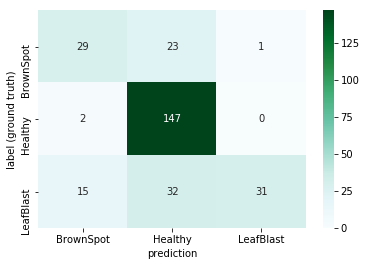

	Best validation accuracy: 73.93
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 2	TRAIN	Loss: 0.66	Correct: 1797/2510(71.59%)
		VALID.:	Loss: 0.58	Correct: 226/280(80.71%)
----------------------------------------


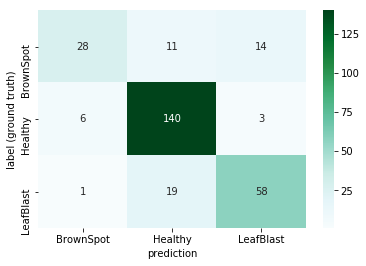

	Best validation accuracy: 80.71
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 3	TRAIN	Loss: 0.34	Correct: 1871/2510(74.54%)
		VALID.:	Loss: 0.49	Correct: 235/280(83.93%)
----------------------------------------


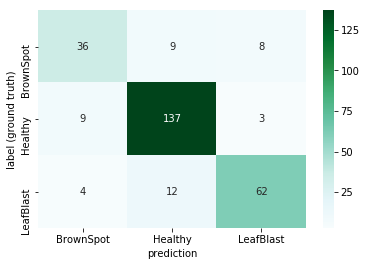

	Best validation accuracy: 83.93
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 4	TRAIN	Loss: 0.97	Correct: 1863/2510(74.22%)
		VALID.:	Loss: 0.37	Correct: 233/280(83.21%)
----------------------------------------


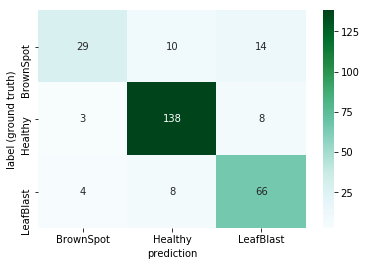

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 5	TRAIN	Loss: 0.31	Correct: 1899/2510(75.66%)
		VALID.:	Loss: 0.61	Correct: 223/280(79.64%)
----------------------------------------


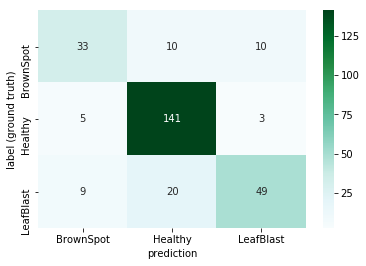

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 6	TRAIN	Loss: 0.26	Correct: 1932/2510(76.97%)
		VALID.:	Loss: 0.42	Correct: 224/280(80.0%)
----------------------------------------


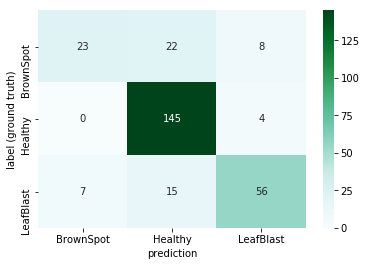

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 7	TRAIN	Loss: 0.74	Correct: 1931/2510(76.93%)
		VALID.:	Loss: 0.49	Correct: 228/280(81.43%)
----------------------------------------


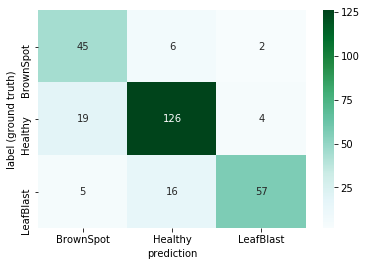

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 8	TRAIN	Loss: 0.45	Correct: 1924/2510(76.65%)
		VALID.:	Loss: 0.63	Correct: 216/280(77.14%)
----------------------------------------


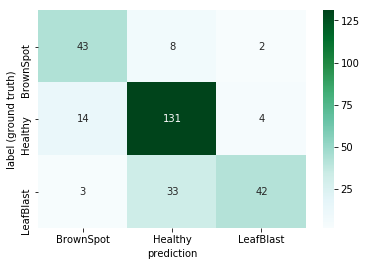

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 9	TRAIN	Loss: 0.51	Correct: 1969/2510(78.45%)
		VALID.:	Loss: 0.35	Correct: 242/280(86.43%)
----------------------------------------


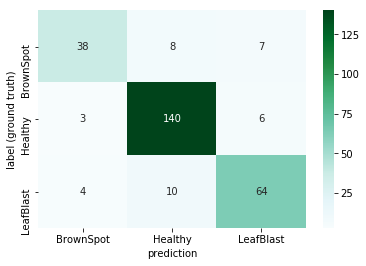

	Best validation accuracy: 86.43
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 10	TRAIN	Loss: 0.38	Correct: 1964/2510(78.25%)
		VALID.:	Loss: 0.51	Correct: 234/280(83.57%)
----------------------------------------


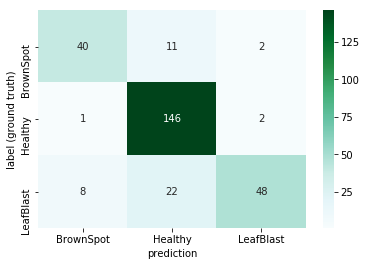

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 11	TRAIN	Loss: 0.51	Correct: 1990/2510(79.28%)
		VALID.:	Loss: 0.5	Correct: 228/280(81.43%)
----------------------------------------


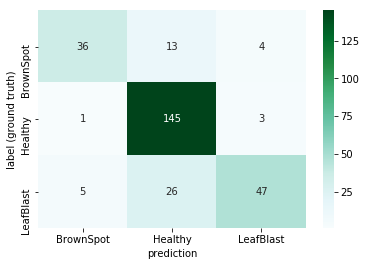

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 12	TRAIN	Loss: 0.64	Correct: 1993/2510(79.4%)
		VALID.:	Loss: 0.44	Correct: 242/280(86.43%)
----------------------------------------


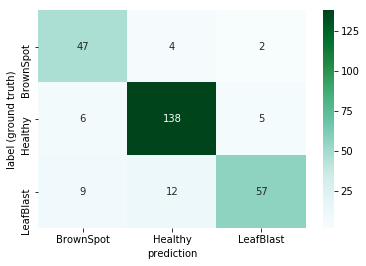

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 13	TRAIN	Loss: 0.87	Correct: 1962/2510(78.17%)
		VALID.:	Loss: 0.33	Correct: 240/280(85.71%)
----------------------------------------


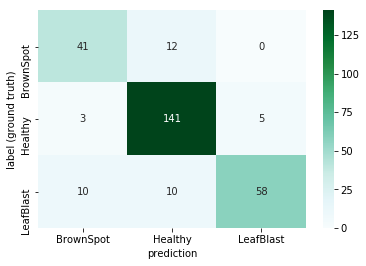

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 14	TRAIN	Loss: 0.21	Correct: 1958/2510(78.01%)
		VALID.:	Loss: 0.56	Correct: 223/280(79.64%)
----------------------------------------


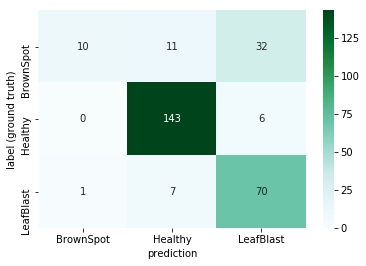

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 15	TRAIN	Loss: 0.43	Correct: 2015/2510(80.28%)
		VALID.:	Loss: 0.49	Correct: 247/280(88.21%)
----------------------------------------


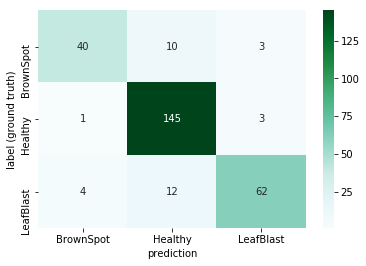

	Best validation accuracy: 88.21
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 16	TRAIN	Loss: 0.59	Correct: 2019/2510(80.44%)
		VALID.:	Loss: 0.36	Correct: 249/280(88.93%)
----------------------------------------


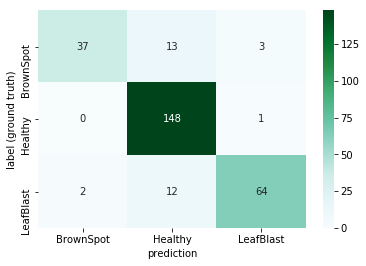

	Best validation accuracy: 88.93
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 17	TRAIN	Loss: 0.5	Correct: 2015/2510(80.28%)
		VALID.:	Loss: 0.32	Correct: 222/280(79.29%)
----------------------------------------


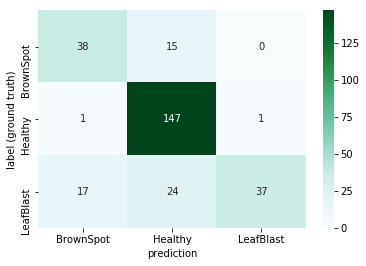

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 18	TRAIN	Loss: 0.74	Correct: 2002/2510(79.76%)
		VALID.:	Loss: 0.44	Correct: 236/280(84.29%)
----------------------------------------


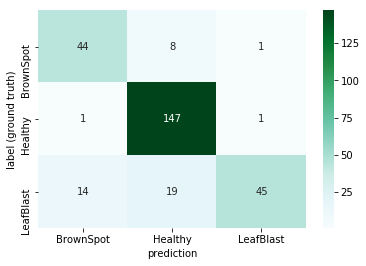

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 19	TRAIN	Loss: 1.01	Correct: 2015/2510(80.28%)
		VALID.:	Loss: 0.36	Correct: 230/280(82.14%)
----------------------------------------


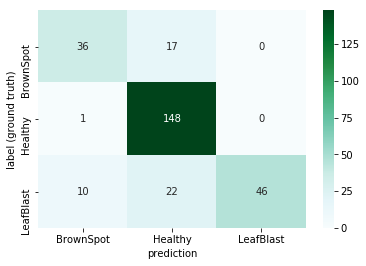

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 20	TRAIN	Loss: 0.74	Correct: 2040/2510(81.27%)
		VALID.:	Loss: 0.4	Correct: 254/280(90.71%)
----------------------------------------


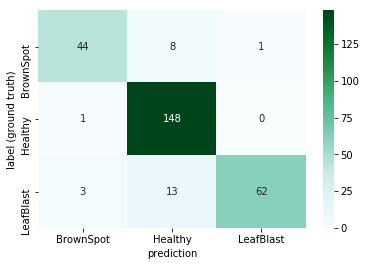

	Best validation accuracy: 90.71
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 21	TRAIN	Loss: 0.58	Correct: 2070/2510(82.47%)
		VALID.:	Loss: 0.29	Correct: 252/280(90.0%)
----------------------------------------


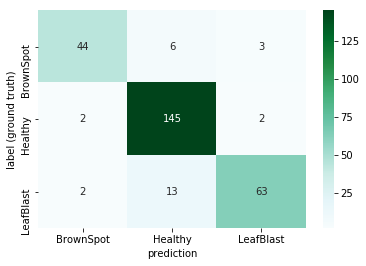

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 22	TRAIN	Loss: 0.66	Correct: 2059/2510(82.03%)
		VALID.:	Loss: 0.35	Correct: 255/280(91.07%)
----------------------------------------


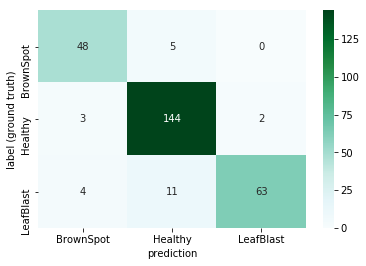

	Best validation accuracy: 91.07
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 23	TRAIN	Loss: 0.5	Correct: 2043/2510(81.39%)
		VALID.:	Loss: 0.33	Correct: 254/280(90.71%)
----------------------------------------


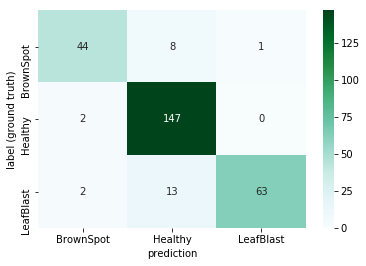

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 24	TRAIN	Loss: 0.39	Correct: 2058/2510(81.99%)
		VALID.:	Loss: 0.51	Correct: 228/280(81.43%)
----------------------------------------


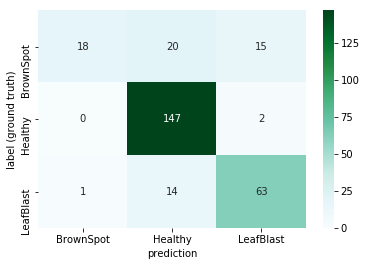

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 25	TRAIN	Loss: 0.54	Correct: 2055/2510(81.87%)
		VALID.:	Loss: 0.4	Correct: 245/280(87.5%)
----------------------------------------


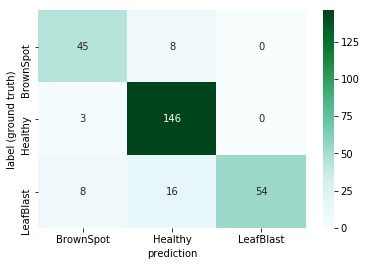

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 26	TRAIN	Loss: 0.82	Correct: 2069/2510(82.43%)
		VALID.:	Loss: 0.31	Correct: 244/280(87.14%)
----------------------------------------


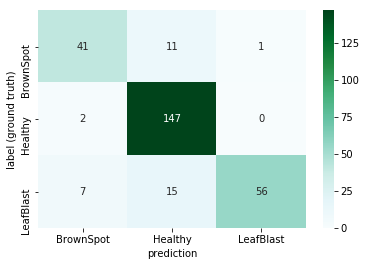

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 27	TRAIN	Loss: 0.16	Correct: 2098/2510(83.59%)
		VALID.:	Loss: 0.38	Correct: 252/280(90.0%)
----------------------------------------


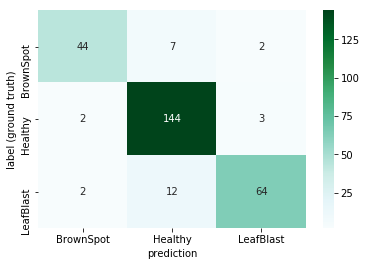

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 28	TRAIN	Loss: 1.51	Correct: 2080/2510(82.87%)
		VALID.:	Loss: 0.21	Correct: 255/280(91.07%)
----------------------------------------


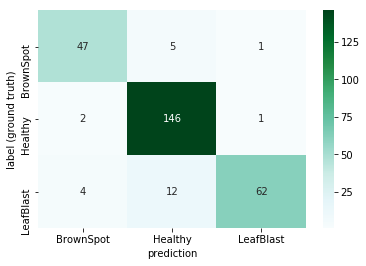

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 29	TRAIN	Loss: 0.58	Correct: 2077/2510(82.75%)
		VALID.:	Loss: 0.3	Correct: 244/280(87.14%)
----------------------------------------


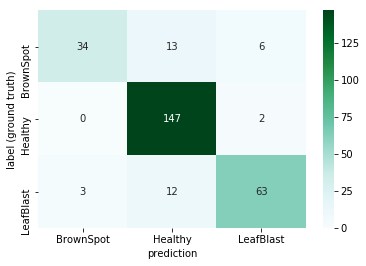

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 30	TRAIN	Loss: 0.11	Correct: 2099/2510(83.63%)
		VALID.:	Loss: 0.35	Correct: 238/280(85.0%)
----------------------------------------


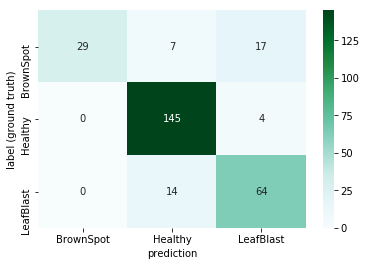

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 31	TRAIN	Loss: 0.27	Correct: 2106/2510(83.9%)
		VALID.:	Loss: 0.23	Correct: 246/280(87.86%)
----------------------------------------


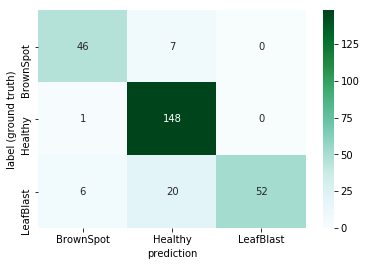

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 32	TRAIN	Loss: 0.72	Correct: 2075/2510(82.67%)
		VALID.:	Loss: 0.23	Correct: 247/280(88.21%)
----------------------------------------


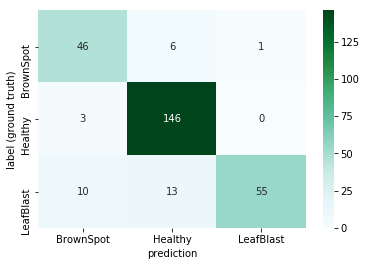

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 33	TRAIN	Loss: 0.38	Correct: 2075/2510(82.67%)
		VALID.:	Loss: 0.31	Correct: 251/280(89.64%)
----------------------------------------


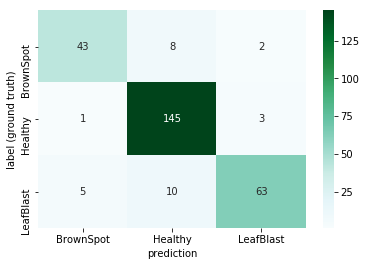

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 34	TRAIN	Loss: 0.18	Correct: 2088/2510(83.19%)
		VALID.:	Loss: 0.29	Correct: 254/280(90.71%)
----------------------------------------


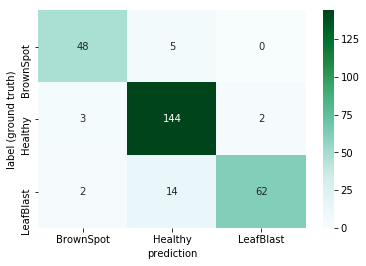

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 35	TRAIN	Loss: 0.19	Correct: 2076/2510(82.71%)
		VALID.:	Loss: 0.39	Correct: 253/280(90.36%)
----------------------------------------


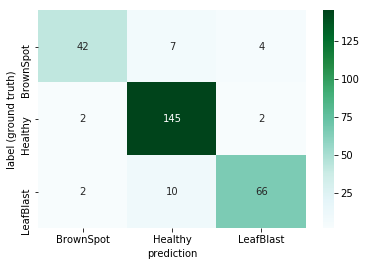

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 36	TRAIN	Loss: 0.92	Correct: 2067/2510(82.35%)
		VALID.:	Loss: 0.26	Correct: 255/280(91.07%)
----------------------------------------


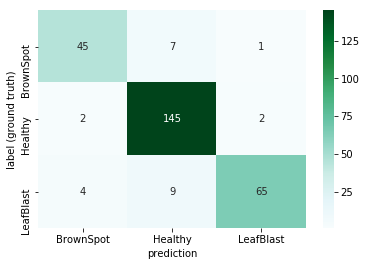

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 37	TRAIN	Loss: 0.62	Correct: 2090/2510(83.27%)
		VALID.:	Loss: 0.25	Correct: 256/280(91.43%)
----------------------------------------


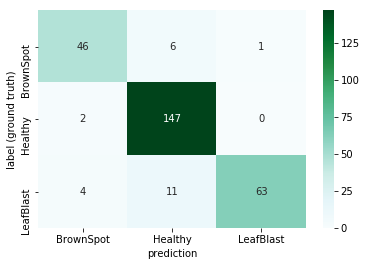

	Best validation accuracy: 91.43
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 38	TRAIN	Loss: 0.25	Correct: 2090/2510(83.27%)
		VALID.:	Loss: 0.3	Correct: 251/280(89.64%)
----------------------------------------


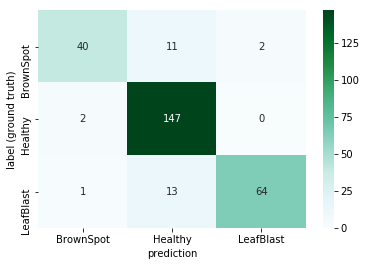

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 39	TRAIN	Loss: 0.7	Correct: 2081/2510(82.91%)
		VALID.:	Loss: 0.44	Correct: 237/280(84.64%)
----------------------------------------


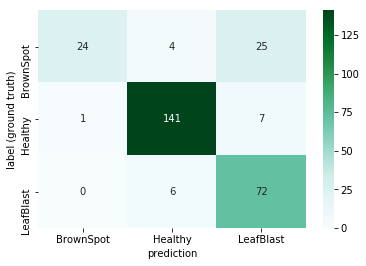

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 40	TRAIN	Loss: 0.59	Correct: 2097/2510(83.55%)
		VALID.:	Loss: 0.35	Correct: 250/280(89.29%)
----------------------------------------


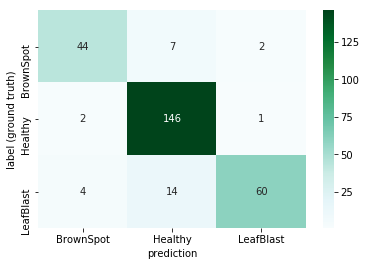

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 41	TRAIN	Loss: 0.48	Correct: 2146/2510(85.5%)
		VALID.:	Loss: 0.37	Correct: 256/280(91.43%)
----------------------------------------


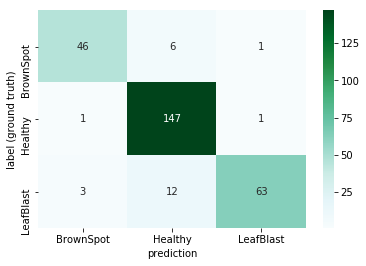

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 42	TRAIN	Loss: 0.46	Correct: 2126/2510(84.7%)
		VALID.:	Loss: 0.28	Correct: 256/280(91.43%)
----------------------------------------


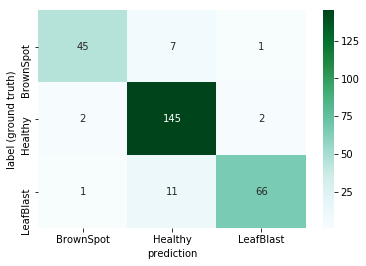

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 43	TRAIN	Loss: 0.17	Correct: 2126/2510(84.7%)
		VALID.:	Loss: 0.2	Correct: 258/280(92.14%)
----------------------------------------


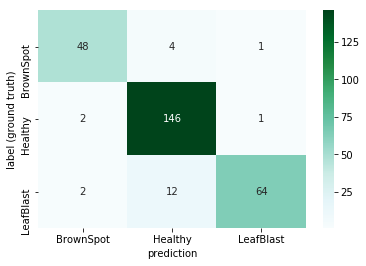

	Best validation accuracy: 92.14
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 44	TRAIN	Loss: 0.17	Correct: 2131/2510(84.9%)
		VALID.:	Loss: 0.39	Correct: 252/280(90.0%)
----------------------------------------


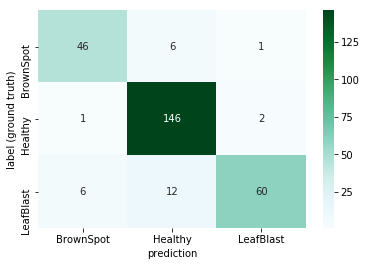

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 45	TRAIN	Loss: 0.23	Correct: 2097/2510(83.55%)
		VALID.:	Loss: 0.38	Correct: 245/280(87.5%)
----------------------------------------


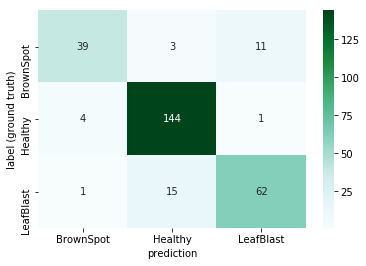

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 46	TRAIN	Loss: 0.37	Correct: 2118/2510(84.38%)
		VALID.:	Loss: 0.26	Correct: 241/280(86.07%)
----------------------------------------


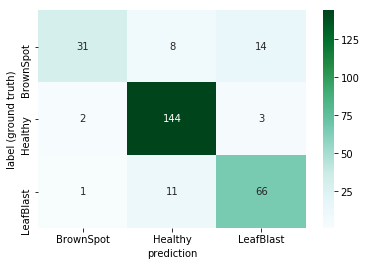

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 47	TRAIN	Loss: 0.11	Correct: 2124/2510(84.62%)
		VALID.:	Loss: 0.34	Correct: 256/280(91.43%)
----------------------------------------


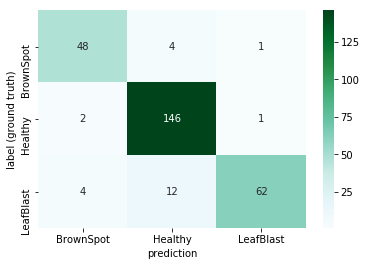

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 48	TRAIN	Loss: 0.41	Correct: 2116/2510(84.3%)
		VALID.:	Loss: 0.4	Correct: 250/280(89.29%)
----------------------------------------


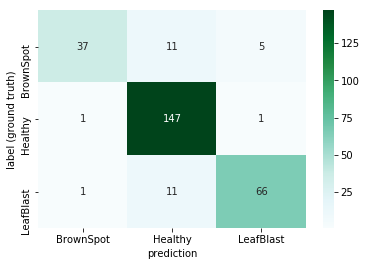

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 49	TRAIN	Loss: 0.87	Correct: 2114/2510(84.22%)
		VALID.:	Loss: 0.35	Correct: 252/280(90.0%)
----------------------------------------


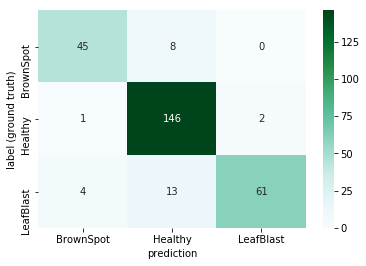

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 50	TRAIN	Loss: 0.26	Correct: 2142/2510(85.34%)
		VALID.:	Loss: 0.26	Correct: 251/280(89.64%)
----------------------------------------


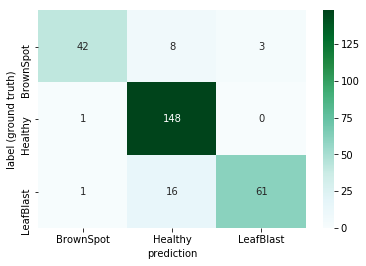

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 51	TRAIN	Loss: 0.22	Correct: 2127/2510(84.74%)
		VALID.:	Loss: 0.34	Correct: 253/280(90.36%)
----------------------------------------


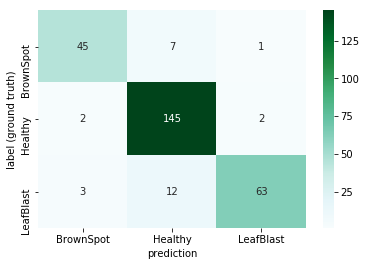

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 52	TRAIN	Loss: 0.1	Correct: 2133/2510(84.98%)
		VALID.:	Loss: 0.3	Correct: 249/280(88.93%)
----------------------------------------


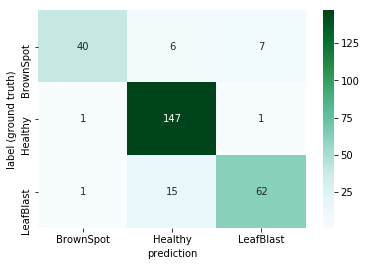

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 53	TRAIN	Loss: 0.66	Correct: 2126/2510(84.7%)
		VALID.:	Loss: 0.25	Correct: 248/280(88.57%)
----------------------------------------


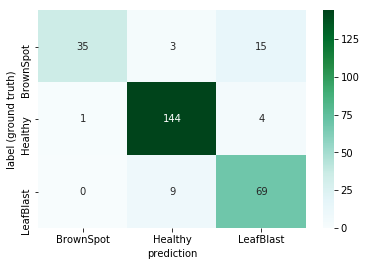

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 54	TRAIN	Loss: 0.45	Correct: 2119/2510(84.42%)
		VALID.:	Loss: 0.32	Correct: 253/280(90.36%)
----------------------------------------


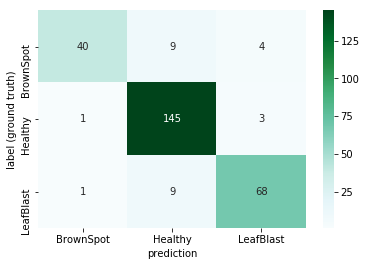

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 55	TRAIN	Loss: 0.83	Correct: 2155/2510(85.86%)
		VALID.:	Loss: 0.27	Correct: 249/280(88.93%)
----------------------------------------


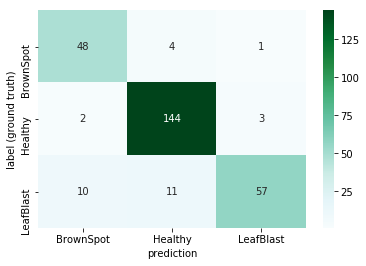

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 56	TRAIN	Loss: 0.41	Correct: 2124/2510(84.62%)
		VALID.:	Loss: 0.26	Correct: 251/280(89.64%)
----------------------------------------


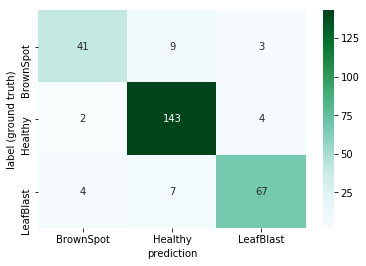

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 57	TRAIN	Loss: 0.2	Correct: 2122/2510(84.54%)
		VALID.:	Loss: 0.33	Correct: 253/280(90.36%)
----------------------------------------


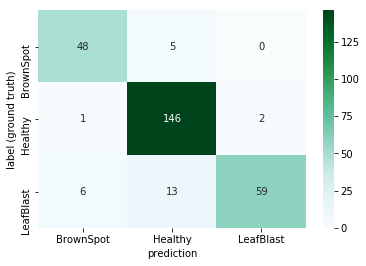

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 58	TRAIN	Loss: 0.49	Correct: 2136/2510(85.1%)
		VALID.:	Loss: 0.34	Correct: 248/280(88.57%)
----------------------------------------


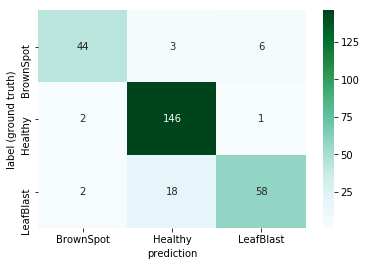

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 59	TRAIN	Loss: 0.22	Correct: 2148/2510(85.58%)
		VALID.:	Loss: 0.25	Correct: 255/280(91.07%)
----------------------------------------


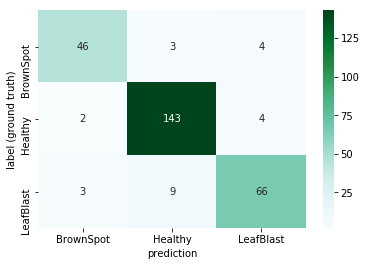

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 60	TRAIN	Loss: 0.43	Correct: 2170/2510(86.45%)
		VALID.:	Loss: 0.42	Correct: 249/280(88.93%)
----------------------------------------


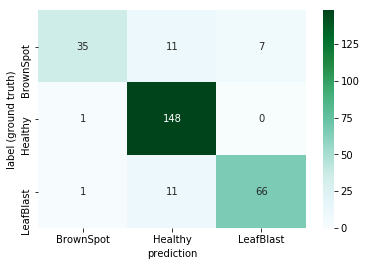

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 61	TRAIN	Loss: 0.62	Correct: 2149/2510(85.62%)
		VALID.:	Loss: 0.23	Correct: 254/280(90.71%)
----------------------------------------


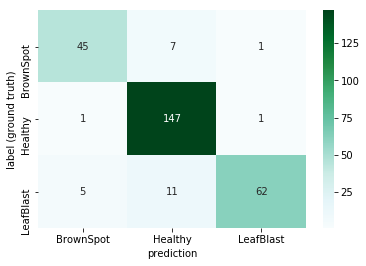

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 62	TRAIN	Loss: 0.39	Correct: 2131/2510(84.9%)
		VALID.:	Loss: 0.32	Correct: 256/280(91.43%)
----------------------------------------


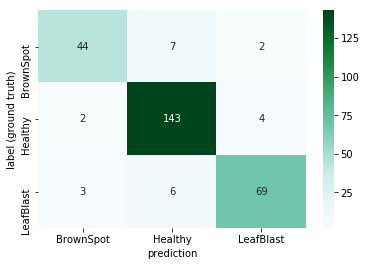

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 63	TRAIN	Loss: 0.22	Correct: 2160/2510(86.06%)
		VALID.:	Loss: 0.26	Correct: 252/280(90.0%)
----------------------------------------


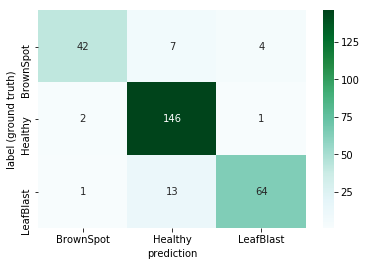

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 64	TRAIN	Loss: 0.21	Correct: 2149/2510(85.62%)
		VALID.:	Loss: 0.15	Correct: 256/280(91.43%)
----------------------------------------


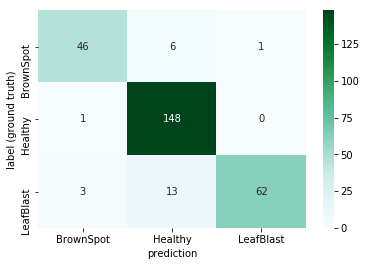

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 65	TRAIN	Loss: 0.27	Correct: 2142/2510(85.34%)
		VALID.:	Loss: 0.31	Correct: 255/280(91.07%)
----------------------------------------


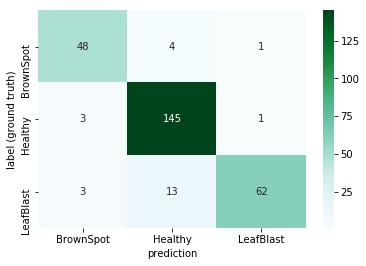

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 66	TRAIN	Loss: 0.56	Correct: 2135/2510(85.06%)
		VALID.:	Loss: 0.26	Correct: 255/280(91.07%)
----------------------------------------


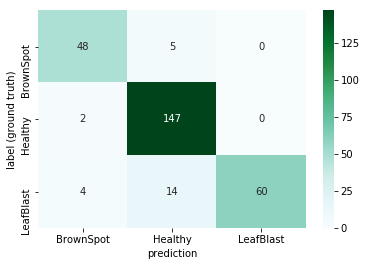

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 67	TRAIN	Loss: 0.11	Correct: 2152/2510(85.74%)
		VALID.:	Loss: 0.24	Correct: 254/280(90.71%)
----------------------------------------


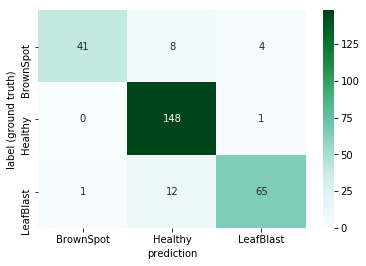

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 68	TRAIN	Loss: 0.14	Correct: 2154/2510(85.82%)
		VALID.:	Loss: 0.22	Correct: 253/280(90.36%)
----------------------------------------


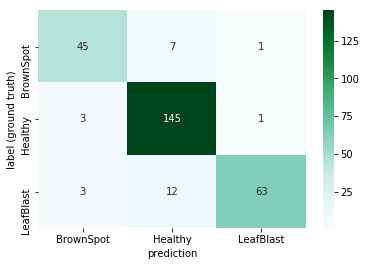

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 69	TRAIN	Loss: 0.52	Correct: 2163/2510(86.18%)
		VALID.:	Loss: 0.23	Correct: 251/280(89.64%)
----------------------------------------


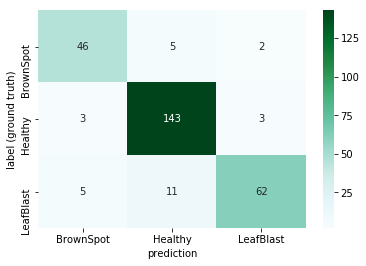

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 70	TRAIN	Loss: 0.22	Correct: 2155/2510(85.86%)
		VALID.:	Loss: 0.22	Correct: 251/280(89.64%)
----------------------------------------


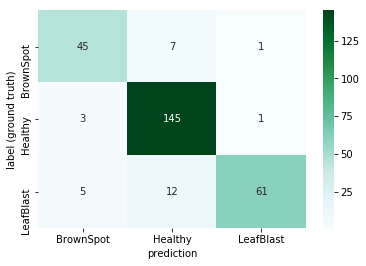

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 71	TRAIN	Loss: 0.26	Correct: 2137/2510(85.14%)
		VALID.:	Loss: 0.36	Correct: 254/280(90.71%)
----------------------------------------


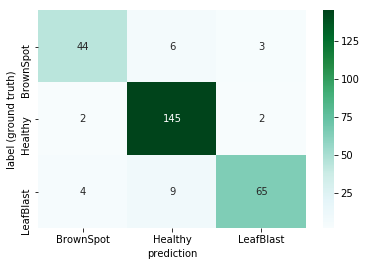

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 72	TRAIN	Loss: 0.53	Correct: 2167/2510(86.33%)
		VALID.:	Loss: 0.3	Correct: 253/280(90.36%)
----------------------------------------


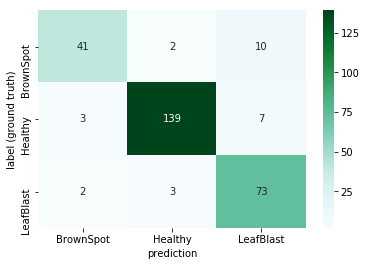

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 73	TRAIN	Loss: 0.16	Correct: 2140/2510(85.26%)
		VALID.:	Loss: 0.44	Correct: 249/280(88.93%)
----------------------------------------


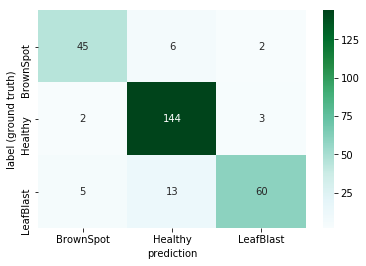

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 74	TRAIN	Loss: 0.93	Correct: 2170/2510(86.45%)
		VALID.:	Loss: 0.31	Correct: 249/280(88.93%)
----------------------------------------


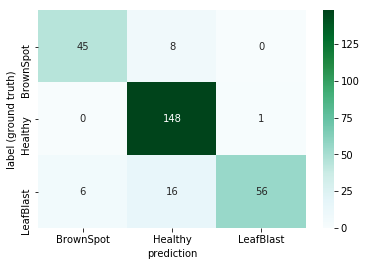

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 75	TRAIN	Loss: 0.13	Correct: 2175/2510(86.65%)
		VALID.:	Loss: 0.44	Correct: 249/280(88.93%)
----------------------------------------


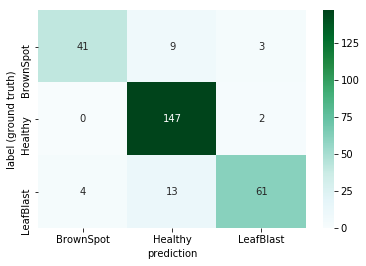

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 76	TRAIN	Loss: 0.4	Correct: 2163/2510(86.18%)
		VALID.:	Loss: 0.2	Correct: 259/280(92.5%)
----------------------------------------


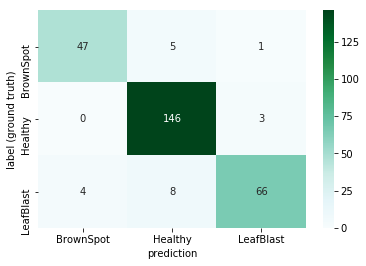

	Best validation accuracy: 92.5
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 77	TRAIN	Loss: 0.14	Correct: 2181/2510(86.89%)
		VALID.:	Loss: 0.2	Correct: 254/280(90.71%)
----------------------------------------


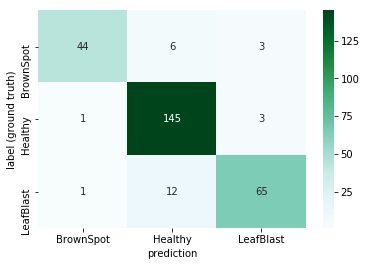

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 78	TRAIN	Loss: 0.35	Correct: 2166/2510(86.29%)
		VALID.:	Loss: 0.23	Correct: 260/280(92.86%)
----------------------------------------


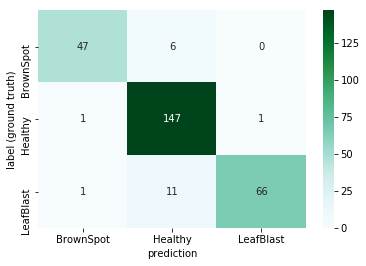

	Best validation accuracy: 92.86
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 79	TRAIN	Loss: 0.25	Correct: 2203/2510(87.77%)
		VALID.:	Loss: 0.39	Correct: 249/280(88.93%)
----------------------------------------


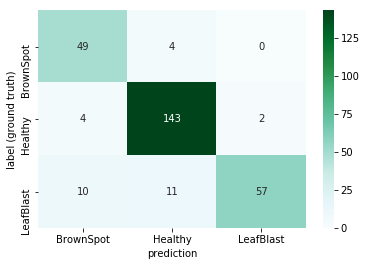

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 80	TRAIN	Loss: 0.35	Correct: 2153/2510(85.78%)
		VALID.:	Loss: 0.18	Correct: 252/280(90.0%)
----------------------------------------


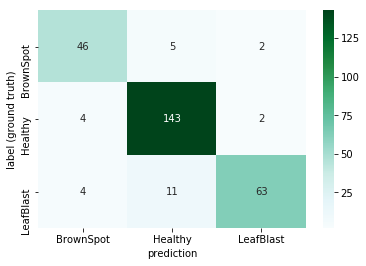

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 81	TRAIN	Loss: 1.03	Correct: 2177/2510(86.73%)
		VALID.:	Loss: 0.2	Correct: 258/280(92.14%)
----------------------------------------


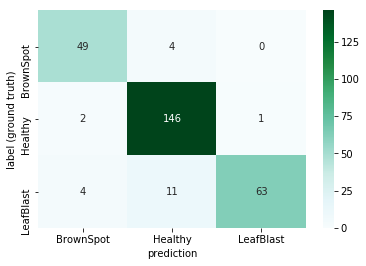

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 82	TRAIN	Loss: 0.8	Correct: 2171/2510(86.49%)
		VALID.:	Loss: 0.21	Correct: 258/280(92.14%)
----------------------------------------


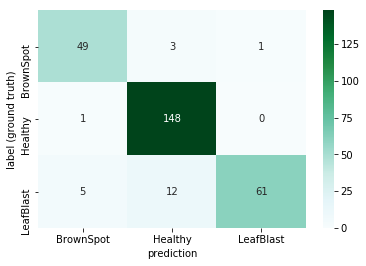

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 83	TRAIN	Loss: 0.1	Correct: 2200/2510(87.65%)
		VALID.:	Loss: 0.27	Correct: 257/280(91.79%)
----------------------------------------


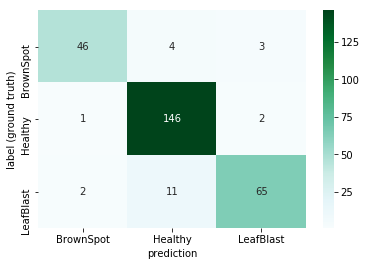

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 84	TRAIN	Loss: 0.45	Correct: 2169/2510(86.41%)
		VALID.:	Loss: 0.19	Correct: 259/280(92.5%)
----------------------------------------


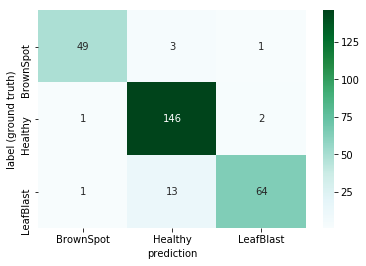

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 85	TRAIN	Loss: 0.41	Correct: 2153/2510(85.78%)
		VALID.:	Loss: 0.27	Correct: 259/280(92.5%)
----------------------------------------


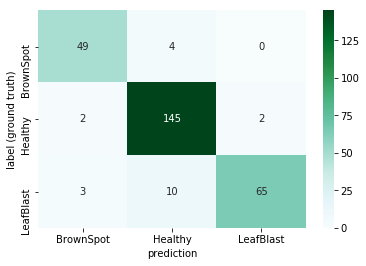

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 86	TRAIN	Loss: 0.66	Correct: 2205/2510(87.85%)
		VALID.:	Loss: 0.2	Correct: 256/280(91.43%)
----------------------------------------


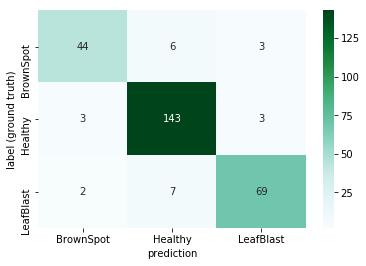

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 87	TRAIN	Loss: 0.36	Correct: 2180/2510(86.85%)
		VALID.:	Loss: 0.34	Correct: 255/280(91.07%)
----------------------------------------


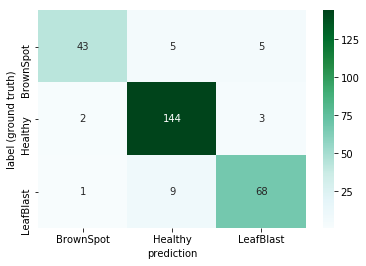

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 88	TRAIN	Loss: 0.66	Correct: 2171/2510(86.49%)
		VALID.:	Loss: 0.27	Correct: 255/280(91.07%)
----------------------------------------


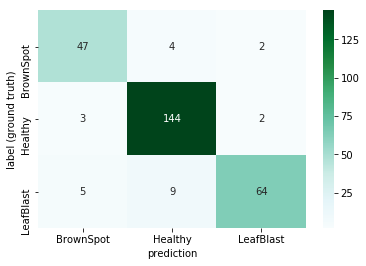

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 89	TRAIN	Loss: 0.22	Correct: 2179/2510(86.81%)
		VALID.:	Loss: 0.22	Correct: 259/280(92.5%)
----------------------------------------


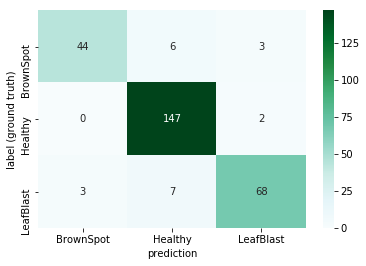

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 90	TRAIN	Loss: 0.17	Correct: 2178/2510(86.77%)
		VALID.:	Loss: 0.18	Correct: 257/280(91.79%)
----------------------------------------


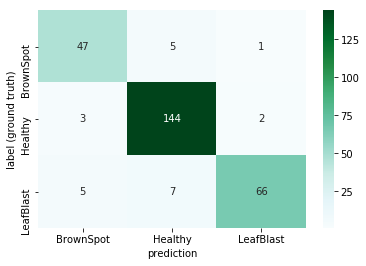

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 91	TRAIN	Loss: 0.57	Correct: 2165/2510(86.25%)
		VALID.:	Loss: 0.15	Correct: 255/280(91.07%)
----------------------------------------


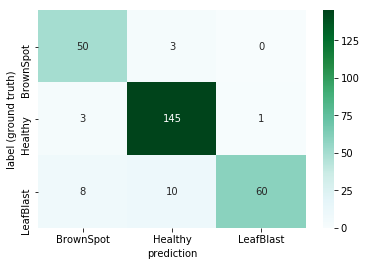

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 92	TRAIN	Loss: 0.22	Correct: 2179/2510(86.81%)
		VALID.:	Loss: 0.33	Correct: 259/280(92.5%)
----------------------------------------


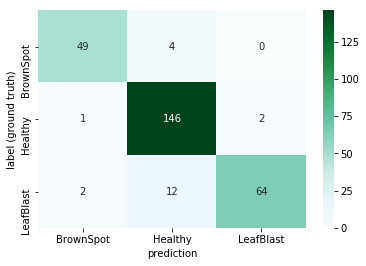

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 93	TRAIN	Loss: 0.23	Correct: 2157/2510(85.94%)
		VALID.:	Loss: 0.28	Correct: 256/280(91.43%)
----------------------------------------


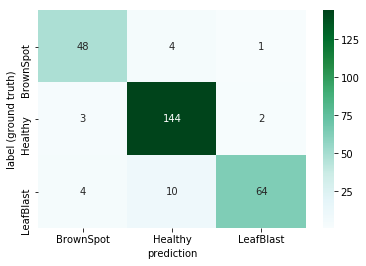

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 94	TRAIN	Loss: 0.24	Correct: 2180/2510(86.85%)
		VALID.:	Loss: 0.2	Correct: 260/280(92.86%)
----------------------------------------


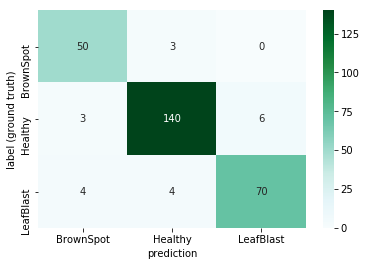

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 95	TRAIN	Loss: 1.32	Correct: 2202/2510(87.73%)
		VALID.:	Loss: 0.16	Correct: 256/280(91.43%)
----------------------------------------


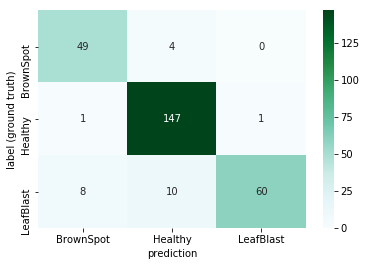

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 96	TRAIN	Loss: 0.68	Correct: 2187/2510(87.13%)
		VALID.:	Loss: 0.29	Correct: 256/280(91.43%)
----------------------------------------


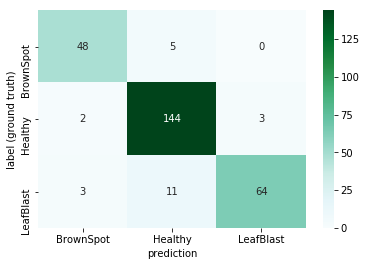

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 97	TRAIN	Loss: 0.46	Correct: 2182/2510(86.93%)
		VALID.:	Loss: 0.23	Correct: 255/280(91.07%)
----------------------------------------


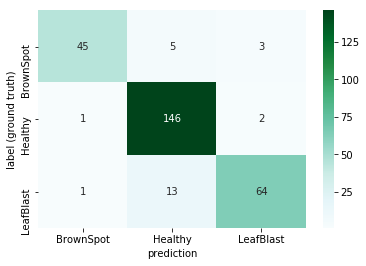

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 98	TRAIN	Loss: 0.42	Correct: 2219/2510(88.41%)
		VALID.:	Loss: 0.22	Correct: 256/280(91.43%)
----------------------------------------


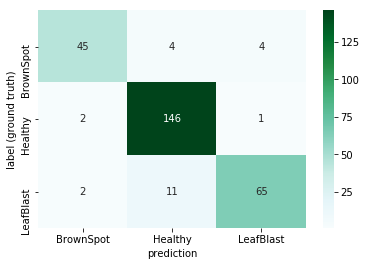

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 99	TRAIN	Loss: 0.13	Correct: 2190/2510(87.25%)
		VALID.:	Loss: 0.44	Correct: 250/280(89.29%)
----------------------------------------


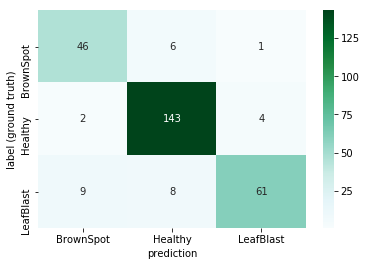

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 100	TRAIN	Loss: 0.83	Correct: 2201/2510(87.69%)
		VALID.:	Loss: 0.29	Correct: 256/280(91.43%)
----------------------------------------


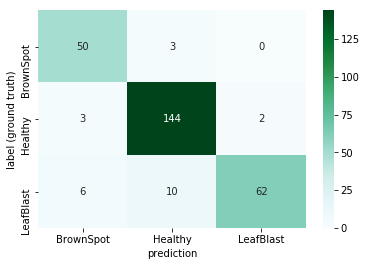

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 101	TRAIN	Loss: 0.13	Correct: 2214/2510(88.21%)
		VALID.:	Loss: 0.27	Correct: 250/280(89.29%)
----------------------------------------


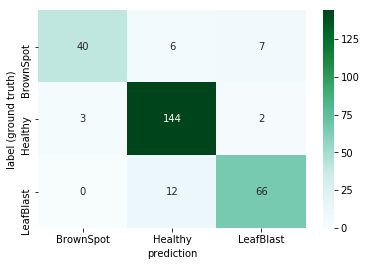

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 102	TRAIN	Loss: 0.38	Correct: 2211/2510(88.09%)
		VALID.:	Loss: 0.29	Correct: 253/280(90.36%)
----------------------------------------


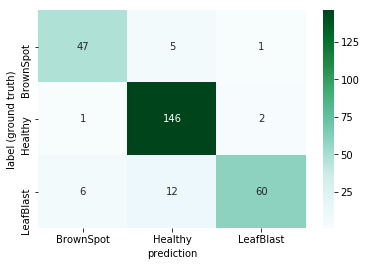

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 103	TRAIN	Loss: 0.36	Correct: 2197/2510(87.53%)
		VALID.:	Loss: 0.25	Correct: 257/280(91.79%)
----------------------------------------


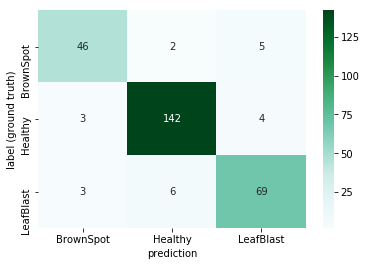

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 104	TRAIN	Loss: 0.7	Correct: 2203/2510(87.77%)
		VALID.:	Loss: 0.24	Correct: 256/280(91.43%)
----------------------------------------


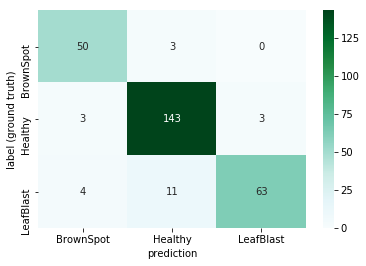

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 105	TRAIN	Loss: 0.16	Correct: 2193/2510(87.37%)
		VALID.:	Loss: 0.25	Correct: 256/280(91.43%)
----------------------------------------


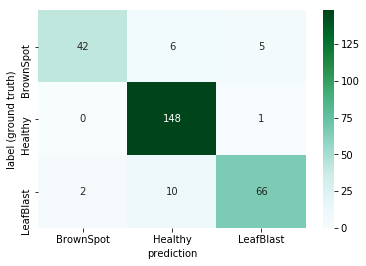

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 106	TRAIN	Loss: 0.14	Correct: 2192/2510(87.33%)
		VALID.:	Loss: 0.14	Correct: 254/280(90.71%)
----------------------------------------


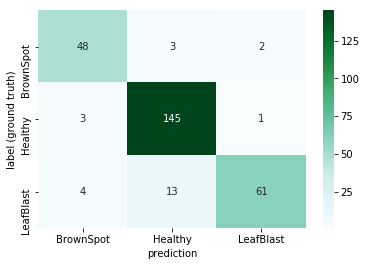

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 107	TRAIN	Loss: 0.07	Correct: 2213/2510(88.17%)
		VALID.:	Loss: 0.32	Correct: 255/280(91.07%)
----------------------------------------


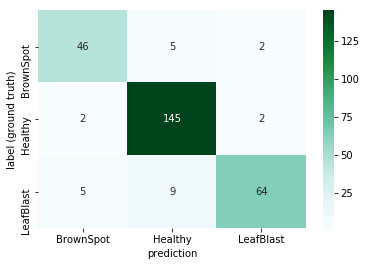

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 108	TRAIN	Loss: 0.2	Correct: 2228/2510(88.76%)
		VALID.:	Loss: 0.4	Correct: 254/280(90.71%)
----------------------------------------


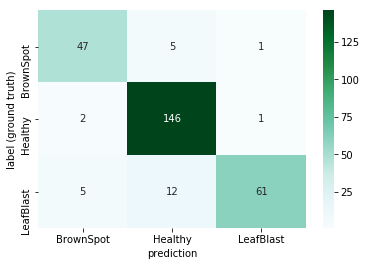

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 109	TRAIN	Loss: 0.55	Correct: 2191/2510(87.29%)
		VALID.:	Loss: 0.18	Correct: 261/280(93.21%)
----------------------------------------


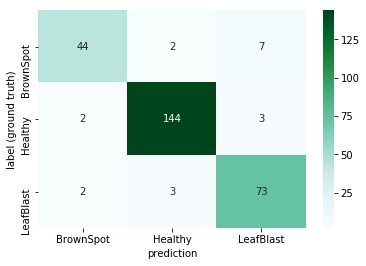

	Best validation accuracy: 93.21
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 110	TRAIN	Loss: 0.23	Correct: 2201/2510(87.69%)
		VALID.:	Loss: 0.2	Correct: 250/280(89.29%)
----------------------------------------


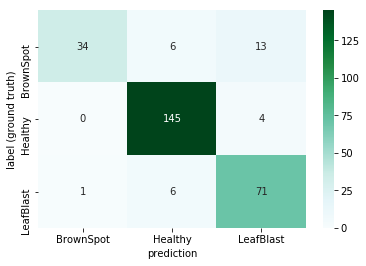

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 111	TRAIN	Loss: 0.26	Correct: 2220/2510(88.45%)
		VALID.:	Loss: 0.29	Correct: 252/280(90.0%)
----------------------------------------


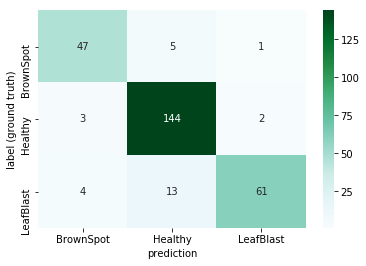

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 112	TRAIN	Loss: 0.31	Correct: 2210/2510(88.05%)
		VALID.:	Loss: 0.36	Correct: 251/280(89.64%)
----------------------------------------


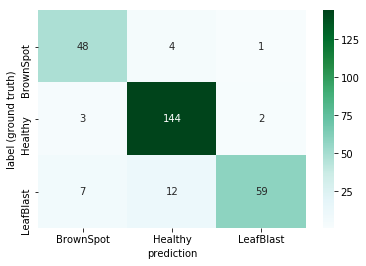

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 113	TRAIN	Loss: 0.16	Correct: 2180/2510(86.85%)
		VALID.:	Loss: 0.22	Correct: 254/280(90.71%)
----------------------------------------


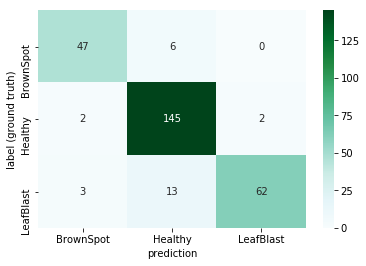

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 114	TRAIN	Loss: 0.19	Correct: 2209/2510(88.01%)
		VALID.:	Loss: 0.25	Correct: 258/280(92.14%)
----------------------------------------


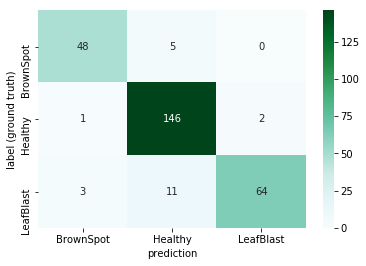

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 115	TRAIN	Loss: 0.16	Correct: 2198/2510(87.57%)
		VALID.:	Loss: 0.4	Correct: 251/280(89.64%)
----------------------------------------


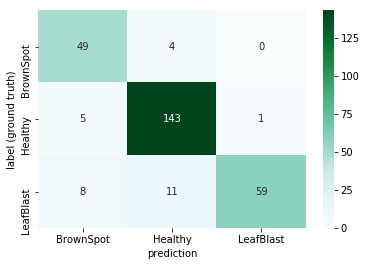

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 116	TRAIN	Loss: 0.25	Correct: 2205/2510(87.85%)
		VALID.:	Loss: 0.15	Correct: 255/280(91.07%)
----------------------------------------


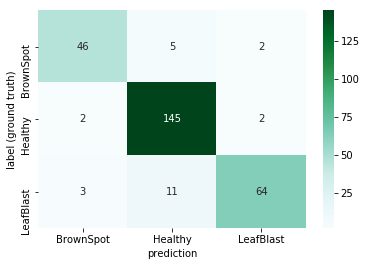

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 117	TRAIN	Loss: 0.38	Correct: 2224/2510(88.61%)
		VALID.:	Loss: 0.16	Correct: 256/280(91.43%)
----------------------------------------


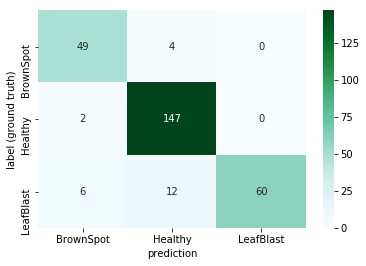

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 118	TRAIN	Loss: 0.26	Correct: 2235/2510(89.04%)
		VALID.:	Loss: 0.14	Correct: 255/280(91.07%)
----------------------------------------


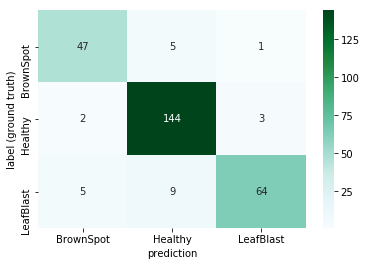

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 119	TRAIN	Loss: 0.9	Correct: 2227/2510(88.73%)
		VALID.:	Loss: 0.1	Correct: 256/280(91.43%)
----------------------------------------


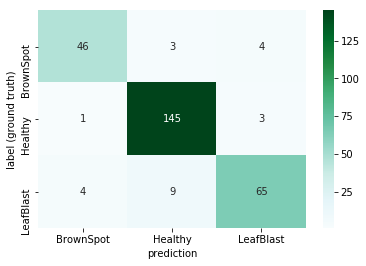

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 120	TRAIN	Loss: 0.37	Correct: 2219/2510(88.41%)
		VALID.:	Loss: 0.27	Correct: 258/280(92.14%)
----------------------------------------


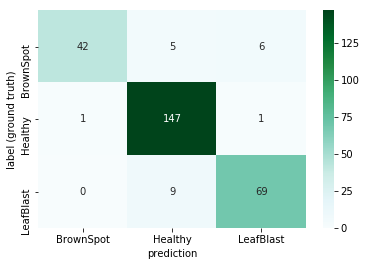

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 121	TRAIN	Loss: 0.05	Correct: 2211/2510(88.09%)
		VALID.:	Loss: 0.28	Correct: 258/280(92.14%)
----------------------------------------


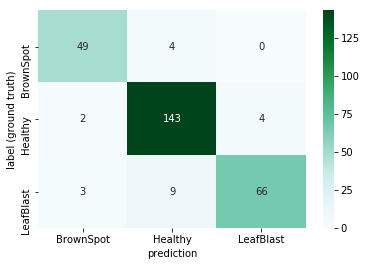

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 122	TRAIN	Loss: 0.11	Correct: 2227/2510(88.73%)
		VALID.:	Loss: 0.2	Correct: 260/280(92.86%)
----------------------------------------


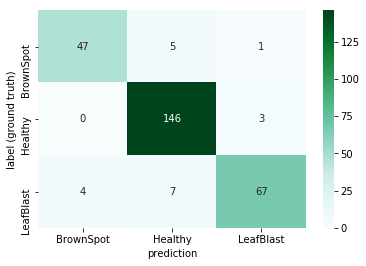

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 123	TRAIN	Loss: 0.12	Correct: 2205/2510(87.85%)
		VALID.:	Loss: 0.34	Correct: 257/280(91.79%)
----------------------------------------


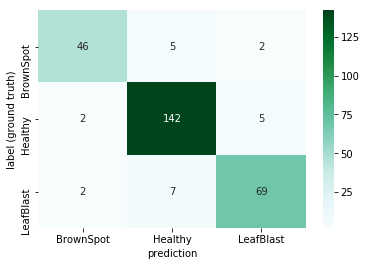

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 124	TRAIN	Loss: 0.92	Correct: 2222/2510(88.53%)
		VALID.:	Loss: 0.12	Correct: 257/280(91.79%)
----------------------------------------


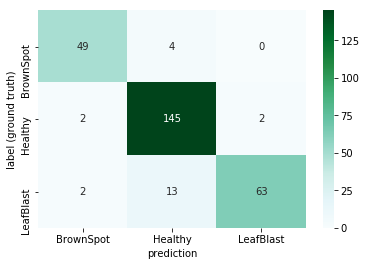

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 125	TRAIN	Loss: 0.86	Correct: 2232/2510(88.92%)
		VALID.:	Loss: 0.28	Correct: 260/280(92.86%)
----------------------------------------


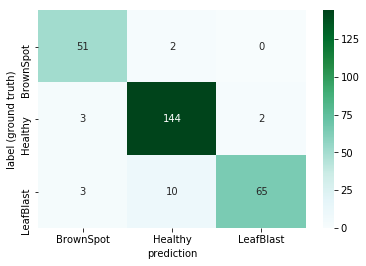

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 126	TRAIN	Loss: 0.18	Correct: 2213/2510(88.17%)
		VALID.:	Loss: 0.23	Correct: 257/280(91.79%)
----------------------------------------


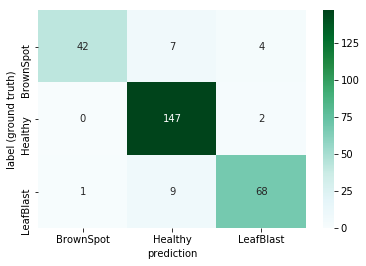

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 127	TRAIN	Loss: 0.26	Correct: 2220/2510(88.45%)
		VALID.:	Loss: 0.24	Correct: 261/280(93.21%)
----------------------------------------


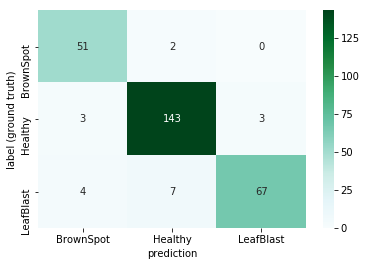

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 128	TRAIN	Loss: 0.06	Correct: 2229/2510(88.8%)
		VALID.:	Loss: 0.18	Correct: 257/280(91.79%)
----------------------------------------


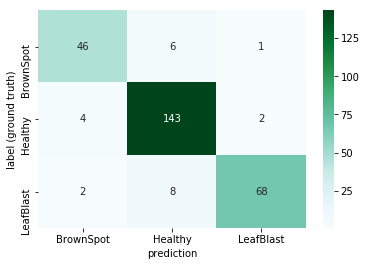

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 129	TRAIN	Loss: 0.17	Correct: 2199/2510(87.61%)
		VALID.:	Loss: 0.12	Correct: 261/280(93.21%)
----------------------------------------


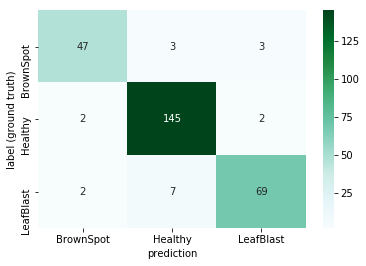

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 130	TRAIN	Loss: 0.48	Correct: 2216/2510(88.29%)
		VALID.:	Loss: 0.25	Correct: 251/280(89.64%)
----------------------------------------


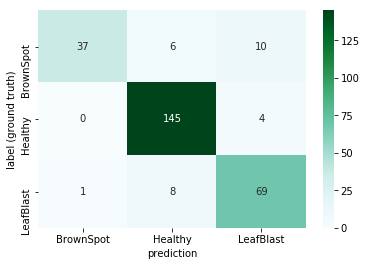

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 131	TRAIN	Loss: 0.52	Correct: 2232/2510(88.92%)
		VALID.:	Loss: 0.19	Correct: 258/280(92.14%)
----------------------------------------


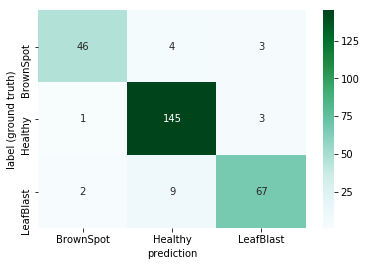

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 132	TRAIN	Loss: 0.19	Correct: 2204/2510(87.81%)
		VALID.:	Loss: 0.33	Correct: 261/280(93.21%)
----------------------------------------


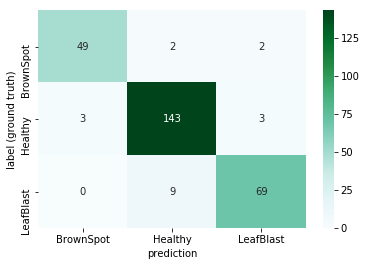

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 133	TRAIN	Loss: 0.37	Correct: 2239/2510(89.2%)
		VALID.:	Loss: 0.26	Correct: 259/280(92.5%)
----------------------------------------


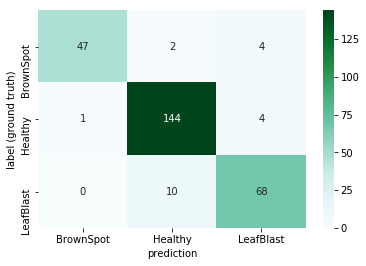

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 134	TRAIN	Loss: 0.31	Correct: 2241/2510(89.28%)
		VALID.:	Loss: 0.12	Correct: 256/280(91.43%)
----------------------------------------


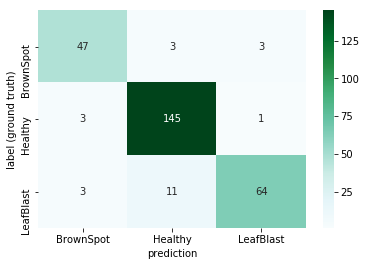

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 135	TRAIN	Loss: 0.38	Correct: 2243/2510(89.36%)
		VALID.:	Loss: 0.24	Correct: 263/280(93.93%)
----------------------------------------


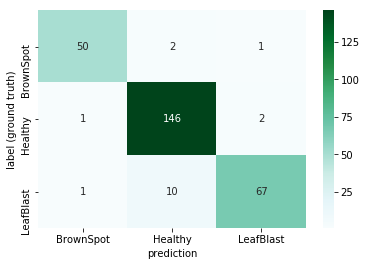

	Best validation accuracy: 93.93
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 136	TRAIN	Loss: 0.62	Correct: 2229/2510(88.8%)
		VALID.:	Loss: 0.21	Correct: 257/280(91.79%)
----------------------------------------


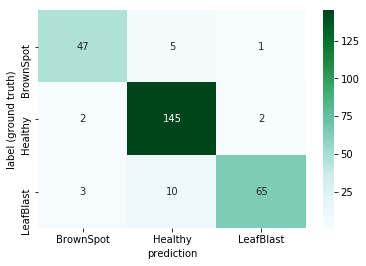

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 137	TRAIN	Loss: 0.33	Correct: 2241/2510(89.28%)
		VALID.:	Loss: 0.16	Correct: 258/280(92.14%)
----------------------------------------


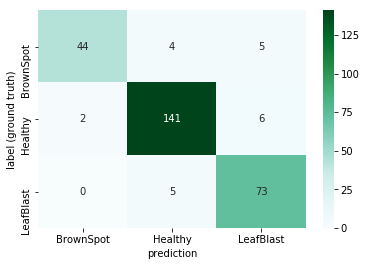

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 138	TRAIN	Loss: 0.34	Correct: 2247/2510(89.52%)
		VALID.:	Loss: 0.3	Correct: 260/280(92.86%)
----------------------------------------


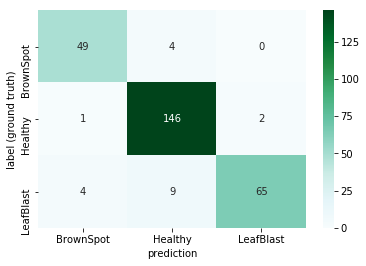

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 139	TRAIN	Loss: 0.35	Correct: 2225/2510(88.65%)
		VALID.:	Loss: 0.25	Correct: 257/280(91.79%)
----------------------------------------


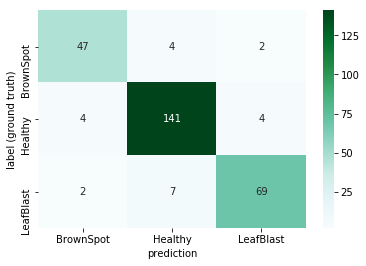

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 140	TRAIN	Loss: 0.17	Correct: 2242/2510(89.32%)
		VALID.:	Loss: 0.25	Correct: 261/280(93.21%)
----------------------------------------


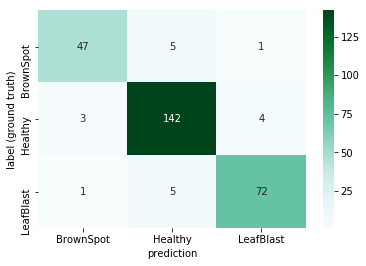

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 141	TRAIN	Loss: 0.27	Correct: 2236/2510(89.08%)
		VALID.:	Loss: 0.32	Correct: 250/280(89.29%)
----------------------------------------


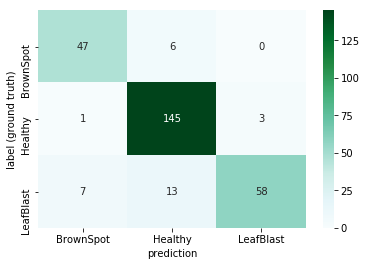

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 142	TRAIN	Loss: 0.11	Correct: 2230/2510(88.84%)
		VALID.:	Loss: 0.19	Correct: 258/280(92.14%)
----------------------------------------


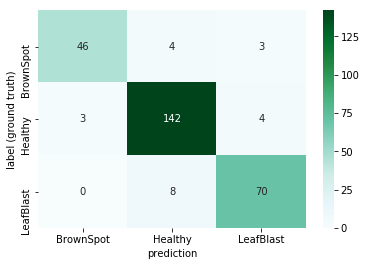

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 143	TRAIN	Loss: 0.08	Correct: 2238/2510(89.16%)
		VALID.:	Loss: 0.17	Correct: 257/280(91.79%)
----------------------------------------


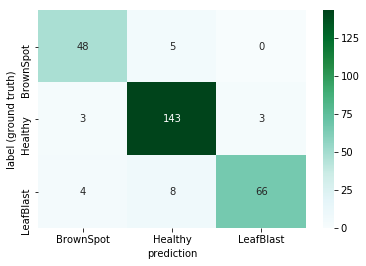

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 144	TRAIN	Loss: 0.19	Correct: 2229/2510(88.8%)
		VALID.:	Loss: 0.18	Correct: 259/280(92.5%)
----------------------------------------


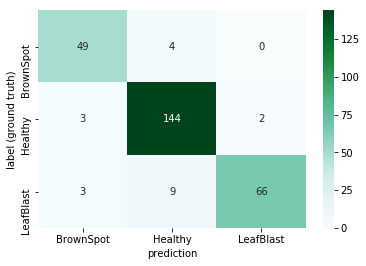

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 145	TRAIN	Loss: 0.34	Correct: 2268/2510(90.36%)
		VALID.:	Loss: 0.36	Correct: 259/280(92.5%)
----------------------------------------


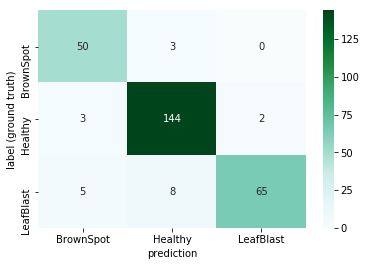

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 146	TRAIN	Loss: 0.46	Correct: 2227/2510(88.73%)
		VALID.:	Loss: 0.24	Correct: 246/280(87.86%)
----------------------------------------


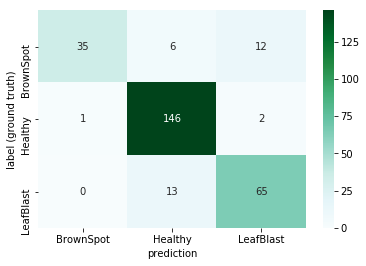

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 147	TRAIN	Loss: 0.07	Correct: 2247/2510(89.52%)
		VALID.:	Loss: 0.38	Correct: 254/280(90.71%)
----------------------------------------


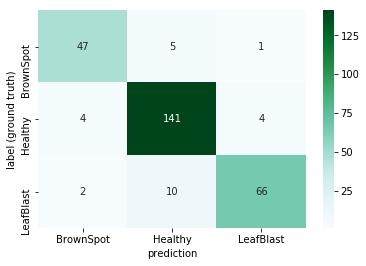

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 148	TRAIN	Loss: 0.24	Correct: 2219/2510(88.41%)
		VALID.:	Loss: 0.33	Correct: 257/280(91.79%)
----------------------------------------


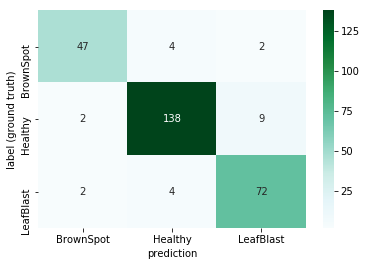

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 149	TRAIN	Loss: 0.16	Correct: 2231/2510(88.88%)
		VALID.:	Loss: 0.16	Correct: 258/280(92.14%)
----------------------------------------


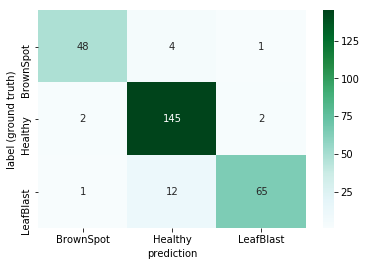

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 150	TRAIN	Loss: 0.07	Correct: 2247/2510(89.52%)
		VALID.:	Loss: 0.16	Correct: 258/280(92.14%)
----------------------------------------


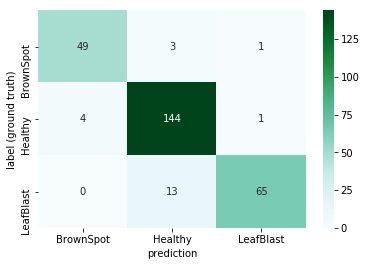

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 151	TRAIN	Loss: 0.46	Correct: 2236/2510(89.08%)
		VALID.:	Loss: 0.21	Correct: 253/280(90.36%)
----------------------------------------


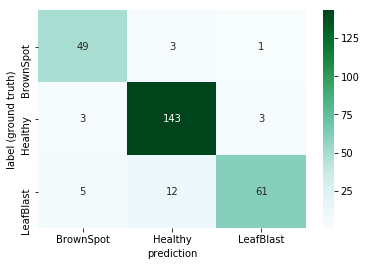

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 152	TRAIN	Loss: 0.19	Correct: 2240/2510(89.24%)
		VALID.:	Loss: 0.3	Correct: 255/280(91.07%)
----------------------------------------


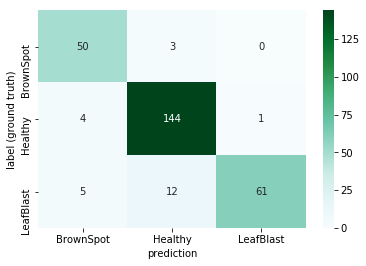

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 153	TRAIN	Loss: 0.11	Correct: 2242/2510(89.32%)
		VALID.:	Loss: 0.24	Correct: 256/280(91.43%)
----------------------------------------


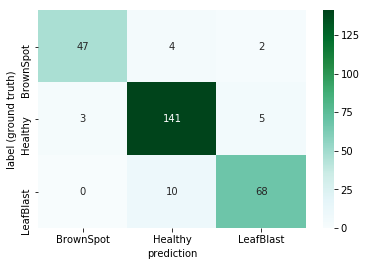

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 154	TRAIN	Loss: 0.3	Correct: 2245/2510(89.44%)
		VALID.:	Loss: 0.2	Correct: 261/280(93.21%)
----------------------------------------


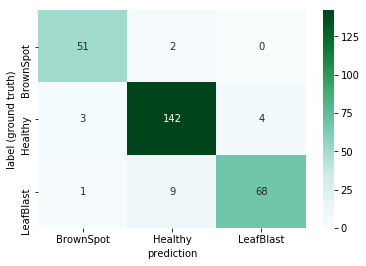

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 155	TRAIN	Loss: 0.63	Correct: 2230/2510(88.84%)
		VALID.:	Loss: 0.27	Correct: 250/280(89.29%)
----------------------------------------


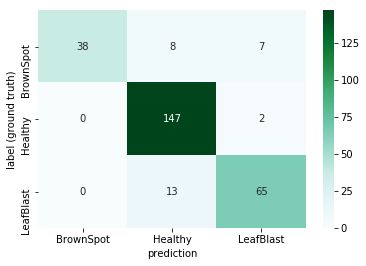

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 156	TRAIN	Loss: 0.16	Correct: 2249/2510(89.6%)
		VALID.:	Loss: 0.12	Correct: 255/280(91.07%)
----------------------------------------


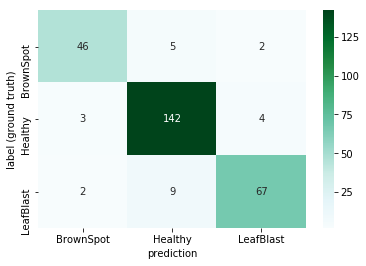

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 157	TRAIN	Loss: 0.39	Correct: 2237/2510(89.12%)
		VALID.:	Loss: 0.16	Correct: 257/280(91.79%)
----------------------------------------


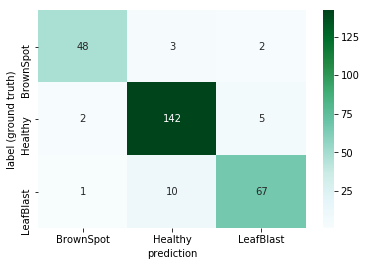

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 158	TRAIN	Loss: 0.06	Correct: 2234/2510(89.0%)
		VALID.:	Loss: 0.29	Correct: 250/280(89.29%)
----------------------------------------


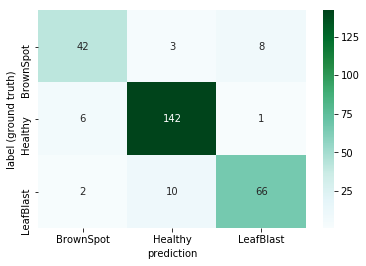

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 159	TRAIN	Loss: 0.16	Correct: 2265/2510(90.24%)
		VALID.:	Loss: 0.25	Correct: 257/280(91.79%)
----------------------------------------


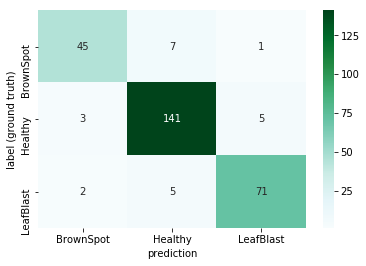

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 160	TRAIN	Loss: 0.18	Correct: 2241/2510(89.28%)
		VALID.:	Loss: 0.32	Correct: 258/280(92.14%)
----------------------------------------


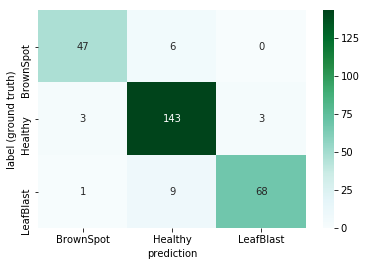

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 161	TRAIN	Loss: 0.48	Correct: 2239/2510(89.2%)
		VALID.:	Loss: 0.25	Correct: 257/280(91.79%)
----------------------------------------


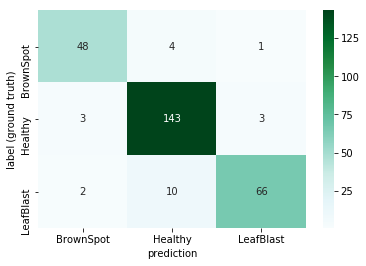

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 162	TRAIN	Loss: 0.17	Correct: 2263/2510(90.16%)
		VALID.:	Loss: 0.32	Correct: 258/280(92.14%)
----------------------------------------


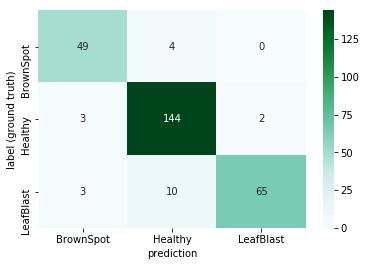

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 163	TRAIN	Loss: 0.08	Correct: 2254/2510(89.8%)
		VALID.:	Loss: 0.32	Correct: 253/280(90.36%)
----------------------------------------


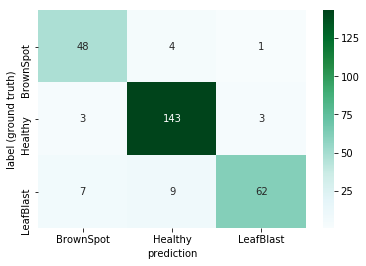

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 164	TRAIN	Loss: 0.41	Correct: 2244/2510(89.4%)
		VALID.:	Loss: 0.41	Correct: 254/280(90.71%)
----------------------------------------


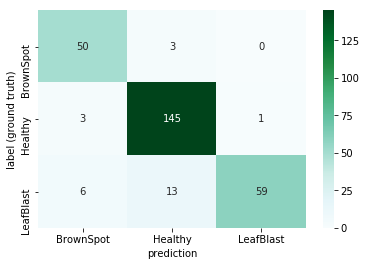

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 165	TRAIN	Loss: 0.46	Correct: 2254/2510(89.8%)
		VALID.:	Loss: 0.2	Correct: 255/280(91.07%)
----------------------------------------


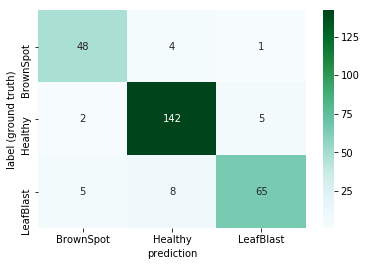

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 166	TRAIN	Loss: 0.16	Correct: 2258/2510(89.96%)
		VALID.:	Loss: 0.4	Correct: 259/280(92.5%)
----------------------------------------


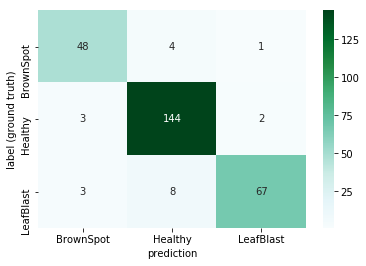

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 167	TRAIN	Loss: 0.15	Correct: 2256/2510(89.88%)
		VALID.:	Loss: 0.12	Correct: 256/280(91.43%)
----------------------------------------


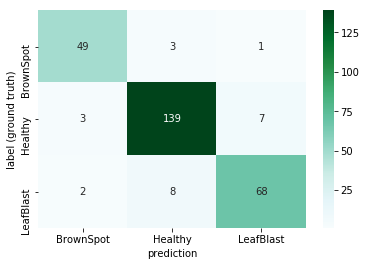

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 168	TRAIN	Loss: 0.09	Correct: 2256/2510(89.88%)
		VALID.:	Loss: 0.16	Correct: 258/280(92.14%)
----------------------------------------


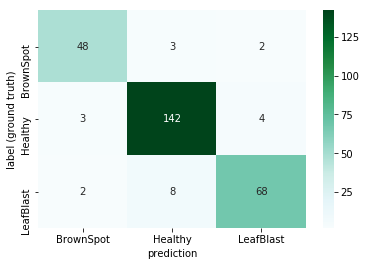

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 169	TRAIN	Loss: 0.15	Correct: 2253/2510(89.76%)
		VALID.:	Loss: 0.17	Correct: 259/280(92.5%)
----------------------------------------


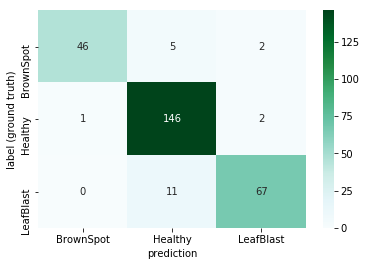

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 170	TRAIN	Loss: 0.26	Correct: 2250/2510(89.64%)
		VALID.:	Loss: 0.26	Correct: 256/280(91.43%)
----------------------------------------


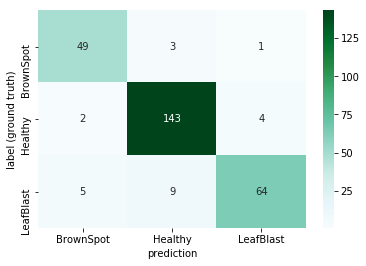

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 171	TRAIN	Loss: 0.13	Correct: 2252/2510(89.72%)
		VALID.:	Loss: 0.22	Correct: 254/280(90.71%)
----------------------------------------


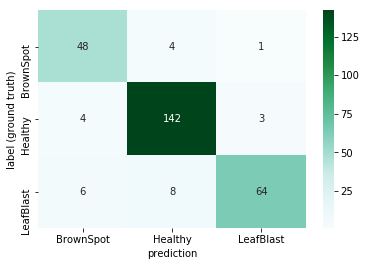

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 172	TRAIN	Loss: 0.33	Correct: 2258/2510(89.96%)
		VALID.:	Loss: 0.31	Correct: 258/280(92.14%)
----------------------------------------


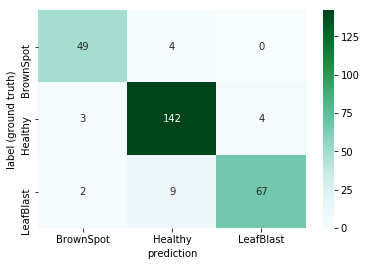

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 173	TRAIN	Loss: 0.81	Correct: 2261/2510(90.08%)
		VALID.:	Loss: 0.31	Correct: 257/280(91.79%)
----------------------------------------


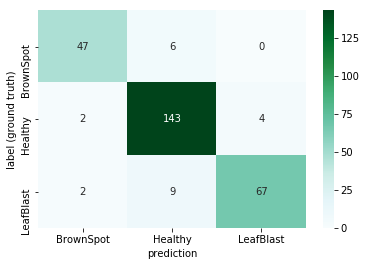

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 174	TRAIN	Loss: 0.1	Correct: 2241/2510(89.28%)
		VALID.:	Loss: 0.17	Correct: 259/280(92.5%)
----------------------------------------


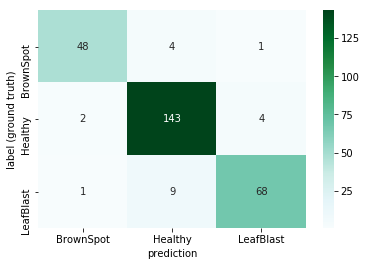

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 175	TRAIN	Loss: 0.76	Correct: 2275/2510(90.64%)
		VALID.:	Loss: 0.26	Correct: 259/280(92.5%)
----------------------------------------


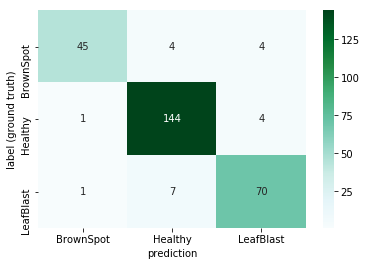

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 176	TRAIN	Loss: 0.39	Correct: 2269/2510(90.4%)
		VALID.:	Loss: 0.3	Correct: 255/280(91.07%)
----------------------------------------


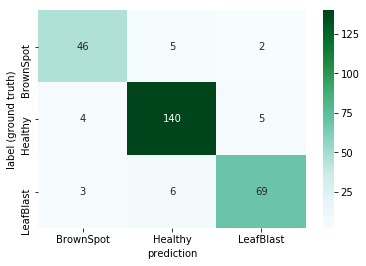

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 177	TRAIN	Loss: 0.09	Correct: 2257/2510(89.92%)
		VALID.:	Loss: 0.4	Correct: 262/280(93.57%)
----------------------------------------


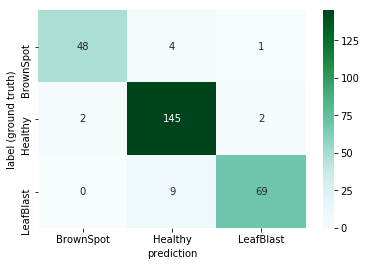

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 178	TRAIN	Loss: 0.06	Correct: 2263/2510(90.16%)
		VALID.:	Loss: 0.28	Correct: 257/280(91.79%)
----------------------------------------


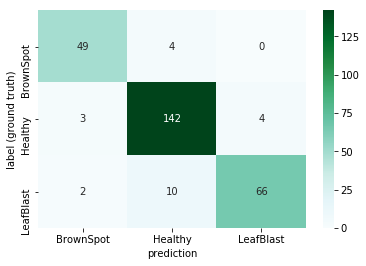

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 179	TRAIN	Loss: 0.05	Correct: 2253/2510(89.76%)
		VALID.:	Loss: 0.46	Correct: 254/280(90.71%)
----------------------------------------


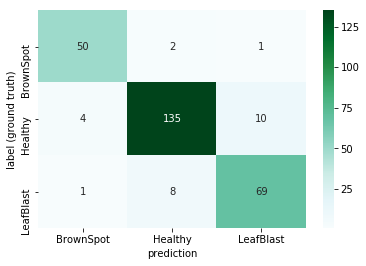

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 180	TRAIN	Loss: 0.32	Correct: 2260/2510(90.04%)
		VALID.:	Loss: 0.23	Correct: 257/280(91.79%)
----------------------------------------


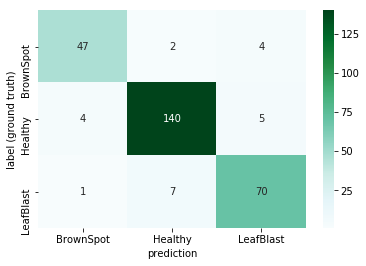

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 181	TRAIN	Loss: 0.26	Correct: 2253/2510(89.76%)
		VALID.:	Loss: 0.21	Correct: 255/280(91.07%)
----------------------------------------


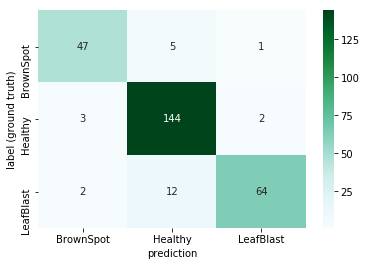

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 182	TRAIN	Loss: 0.13	Correct: 2239/2510(89.2%)
		VALID.:	Loss: 0.28	Correct: 255/280(91.07%)
----------------------------------------


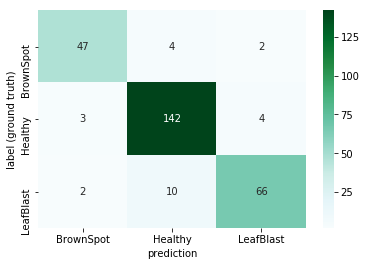

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 183	TRAIN	Loss: 0.23	Correct: 2250/2510(89.64%)
		VALID.:	Loss: 0.16	Correct: 257/280(91.79%)
----------------------------------------


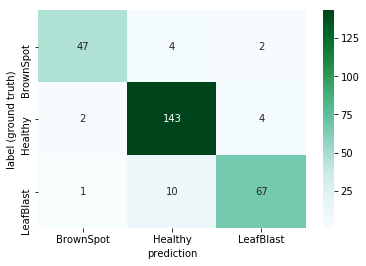

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 184	TRAIN	Loss: 0.49	Correct: 2263/2510(90.16%)
		VALID.:	Loss: 0.32	Correct: 250/280(89.29%)
----------------------------------------


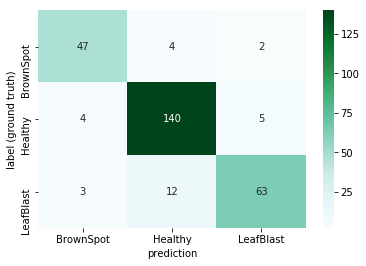

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 185	TRAIN	Loss: 0.11	Correct: 2252/2510(89.72%)
		VALID.:	Loss: 0.32	Correct: 257/280(91.79%)
----------------------------------------


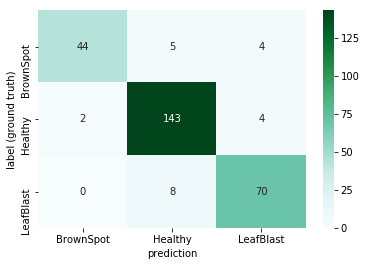

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 186	TRAIN	Loss: 0.06	Correct: 2261/2510(90.08%)
		VALID.:	Loss: 0.37	Correct: 247/280(88.21%)
----------------------------------------


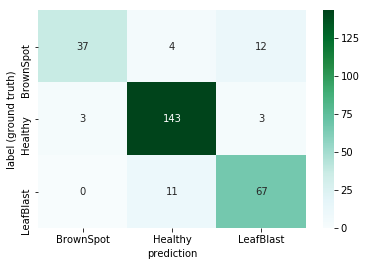

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 187	TRAIN	Loss: 0.25	Correct: 2279/2510(90.8%)
		VALID.:	Loss: 0.21	Correct: 253/280(90.36%)
----------------------------------------


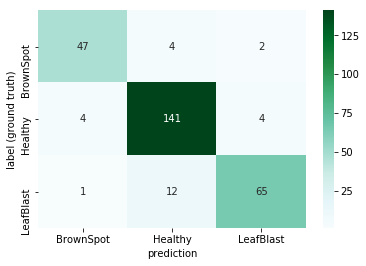

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 188	TRAIN	Loss: 0.29	Correct: 2261/2510(90.08%)
		VALID.:	Loss: 0.28	Correct: 259/280(92.5%)
----------------------------------------


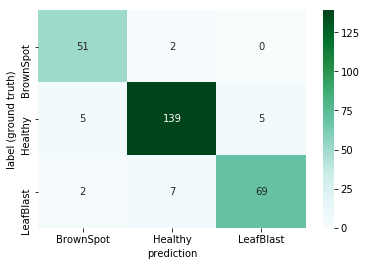

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 189	TRAIN	Loss: 0.09	Correct: 2257/2510(89.92%)
		VALID.:	Loss: 0.23	Correct: 259/280(92.5%)
----------------------------------------


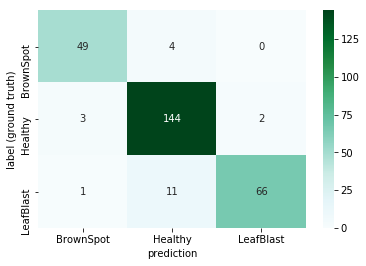

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 190	TRAIN	Loss: 0.37	Correct: 2251/2510(89.68%)
		VALID.:	Loss: 0.23	Correct: 255/280(91.07%)
----------------------------------------


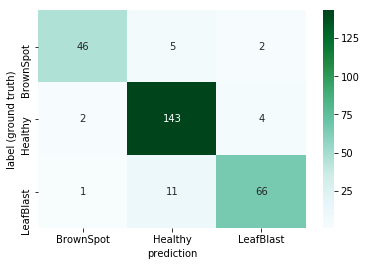

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 191	TRAIN	Loss: 0.08	Correct: 2276/2510(90.68%)
		VALID.:	Loss: 0.26	Correct: 258/280(92.14%)
----------------------------------------


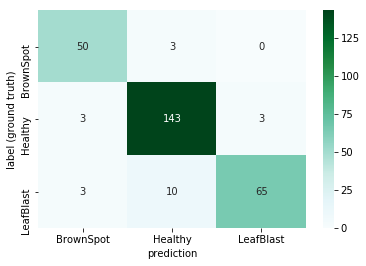

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 192	TRAIN	Loss: 0.25	Correct: 2284/2510(91.0%)
		VALID.:	Loss: 0.22	Correct: 258/280(92.14%)
----------------------------------------


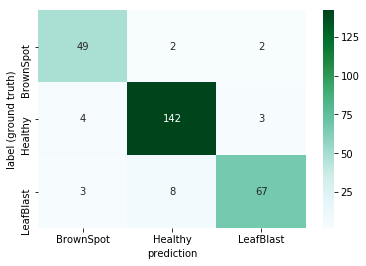

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 193	TRAIN	Loss: 0.2	Correct: 2255/2510(89.84%)
		VALID.:	Loss: 0.14	Correct: 258/280(92.14%)
----------------------------------------


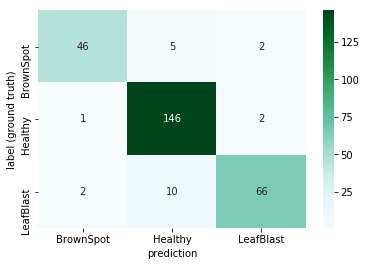

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 194	TRAIN	Loss: 0.33	Correct: 2282/2510(90.92%)
		VALID.:	Loss: 0.31	Correct: 251/280(89.64%)
----------------------------------------


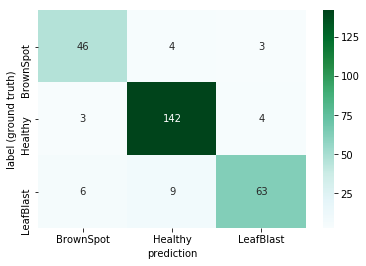

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 195	TRAIN	Loss: 0.18	Correct: 2245/2510(89.44%)
		VALID.:	Loss: 0.21	Correct: 258/280(92.14%)
----------------------------------------


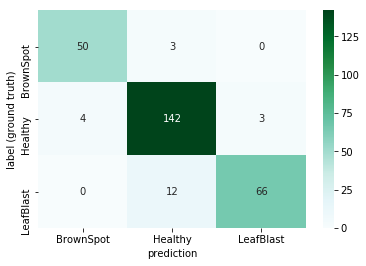

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 196	TRAIN	Loss: 0.13	Correct: 2272/2510(90.52%)
		VALID.:	Loss: 0.31	Correct: 257/280(91.79%)
----------------------------------------


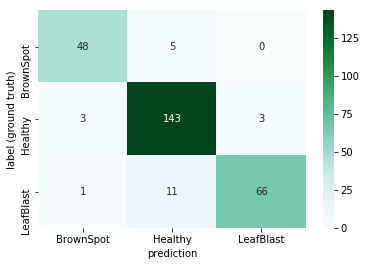

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 197	TRAIN	Loss: 0.2	Correct: 2276/2510(90.68%)
		VALID.:	Loss: 0.26	Correct: 251/280(89.64%)
----------------------------------------


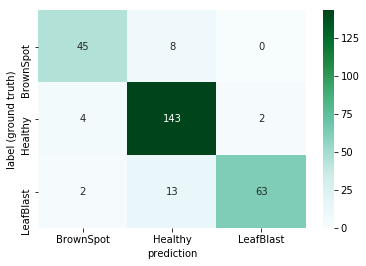

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 198	TRAIN	Loss: 0.02	Correct: 2285/2510(91.04%)
		VALID.:	Loss: 0.18	Correct: 257/280(91.79%)
----------------------------------------


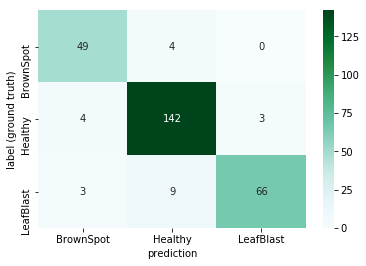

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 199	TRAIN	Loss: 0.16	Correct: 2264/2510(90.2%)
		VALID.:	Loss: 0.16	Correct: 259/280(92.5%)
----------------------------------------


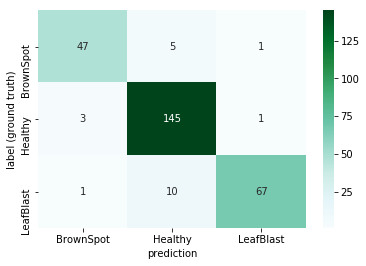

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 200	TRAIN	Loss: 0.21	Correct: 2253/2510(89.76%)
		VALID.:	Loss: 0.21	Correct: 258/280(92.14%)
----------------------------------------


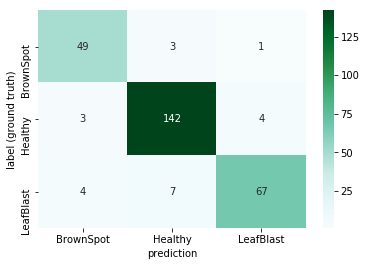

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 201	TRAIN	Loss: 0.54	Correct: 2273/2510(90.56%)
		VALID.:	Loss: 0.24	Correct: 261/280(93.21%)
----------------------------------------


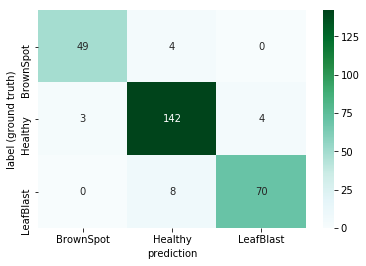

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 202	TRAIN	Loss: 0.86	Correct: 2277/2510(90.72%)
		VALID.:	Loss: 0.19	Correct: 254/280(90.71%)
----------------------------------------


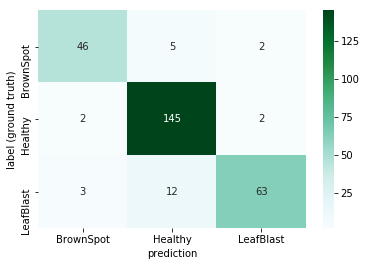

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 203	TRAIN	Loss: 0.12	Correct: 2274/2510(90.6%)
		VALID.:	Loss: 0.18	Correct: 260/280(92.86%)
----------------------------------------


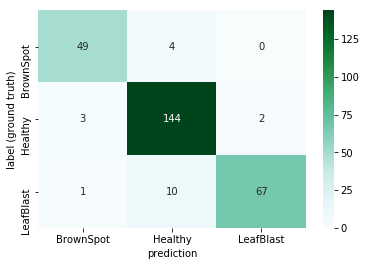

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 204	TRAIN	Loss: 0.55	Correct: 2263/2510(90.16%)
		VALID.:	Loss: 0.2	Correct: 257/280(91.79%)
----------------------------------------


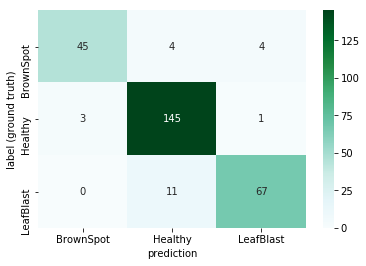

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 205	TRAIN	Loss: 0.4	Correct: 2303/2510(91.75%)
		VALID.:	Loss: 0.28	Correct: 261/280(93.21%)
----------------------------------------


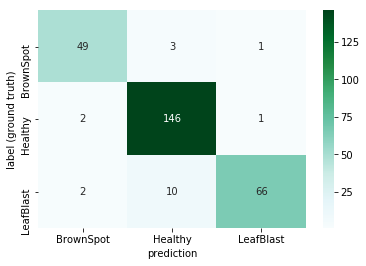

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 206	TRAIN	Loss: 0.06	Correct: 2280/2510(90.84%)
		VALID.:	Loss: 0.57	Correct: 258/280(92.14%)
----------------------------------------


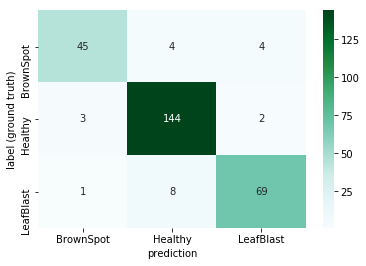

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 207	TRAIN	Loss: 0.12	Correct: 2277/2510(90.72%)
		VALID.:	Loss: 0.39	Correct: 255/280(91.07%)
----------------------------------------


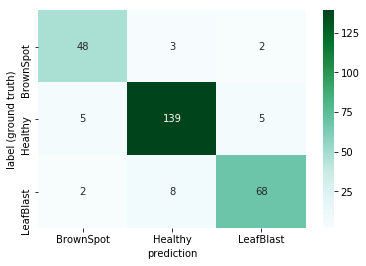

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 208	TRAIN	Loss: 0.05	Correct: 2287/2510(91.12%)
		VALID.:	Loss: 0.16	Correct: 256/280(91.43%)
----------------------------------------


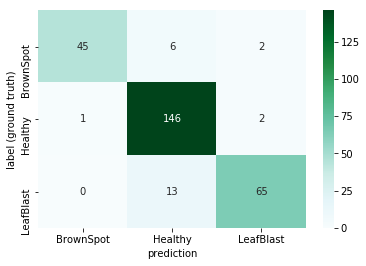

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 209	TRAIN	Loss: 0.13	Correct: 2232/2510(88.92%)
		VALID.:	Loss: 0.26	Correct: 260/280(92.86%)
----------------------------------------


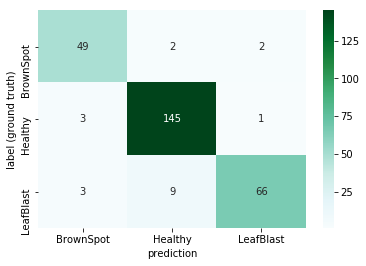

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 210	TRAIN	Loss: 0.23	Correct: 2286/2510(91.08%)
		VALID.:	Loss: 0.27	Correct: 261/280(93.21%)
----------------------------------------


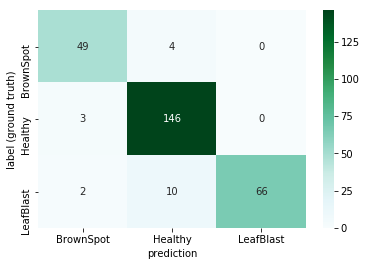

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 211	TRAIN	Loss: 0.07	Correct: 2288/2510(91.16%)
		VALID.:	Loss: 0.31	Correct: 264/280(94.29%)
----------------------------------------


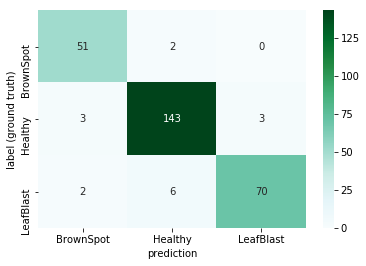

	Best validation accuracy: 94.29
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 212	TRAIN	Loss: 0.38	Correct: 2270/2510(90.44%)
		VALID.:	Loss: 0.41	Correct: 254/280(90.71%)
----------------------------------------


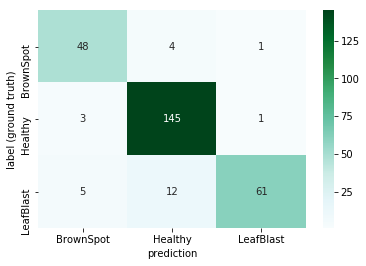

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 213	TRAIN	Loss: 0.1	Correct: 2283/2510(90.96%)
		VALID.:	Loss: 0.26	Correct: 257/280(91.79%)
----------------------------------------


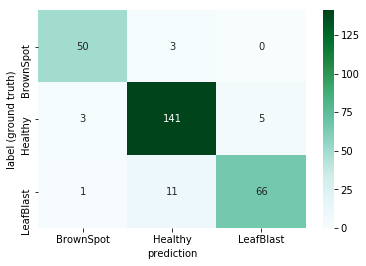

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 214	TRAIN	Loss: 0.38	Correct: 2273/2510(90.56%)
		VALID.:	Loss: 0.19	Correct: 259/280(92.5%)
----------------------------------------


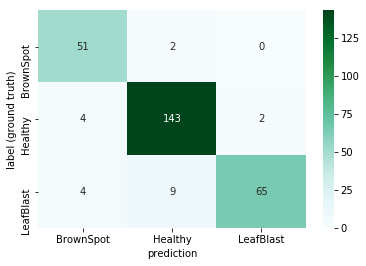

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 215	TRAIN	Loss: 1.54	Correct: 2272/2510(90.52%)
		VALID.:	Loss: 0.22	Correct: 257/280(91.79%)
----------------------------------------


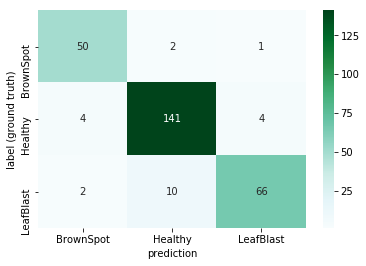

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 216	TRAIN	Loss: 0.68	Correct: 2288/2510(91.16%)
		VALID.:	Loss: 0.2	Correct: 262/280(93.57%)
----------------------------------------


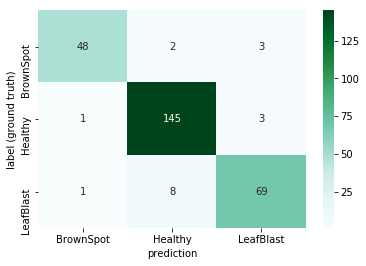

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 217	TRAIN	Loss: 0.07	Correct: 2265/2510(90.24%)
		VALID.:	Loss: 0.28	Correct: 263/280(93.93%)
----------------------------------------


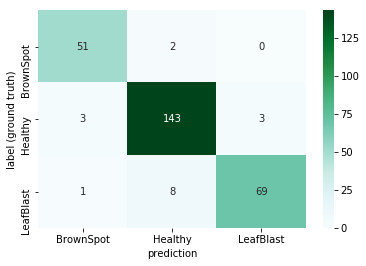

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 218	TRAIN	Loss: 0.3	Correct: 2291/2510(91.27%)
		VALID.:	Loss: 0.43	Correct: 255/280(91.07%)
----------------------------------------


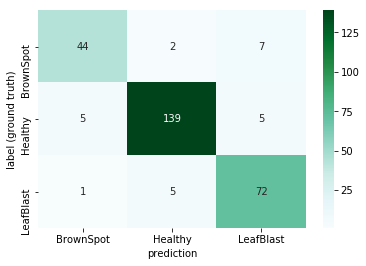

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 219	TRAIN	Loss: 0.69	Correct: 2247/2510(89.52%)
		VALID.:	Loss: 0.47	Correct: 258/280(92.14%)
----------------------------------------


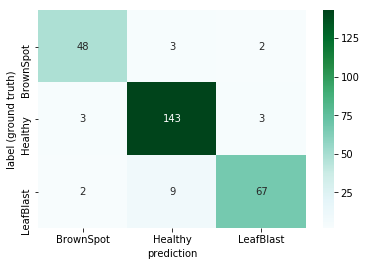

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 220	TRAIN	Loss: 0.41	Correct: 2273/2510(90.56%)
		VALID.:	Loss: 0.29	Correct: 259/280(92.5%)
----------------------------------------


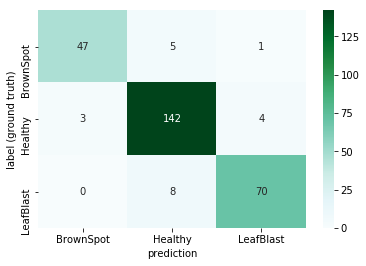

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 221	TRAIN	Loss: 0.17	Correct: 2271/2510(90.48%)
		VALID.:	Loss: 0.3	Correct: 260/280(92.86%)
----------------------------------------


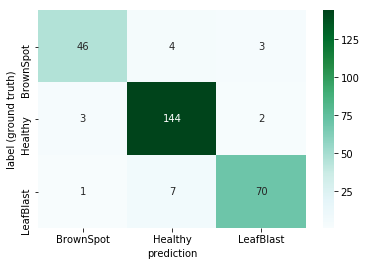

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 222	TRAIN	Loss: 0.45	Correct: 2288/2510(91.16%)
		VALID.:	Loss: 0.24	Correct: 258/280(92.14%)
----------------------------------------


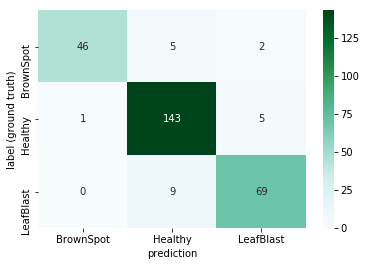

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 223	TRAIN	Loss: 0.06	Correct: 2282/2510(90.92%)
		VALID.:	Loss: 0.17	Correct: 255/280(91.07%)
----------------------------------------


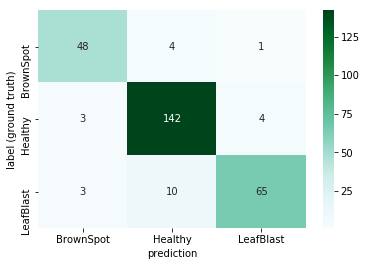

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 224	TRAIN	Loss: 0.23	Correct: 2286/2510(91.08%)
		VALID.:	Loss: 0.44	Correct: 254/280(90.71%)
----------------------------------------


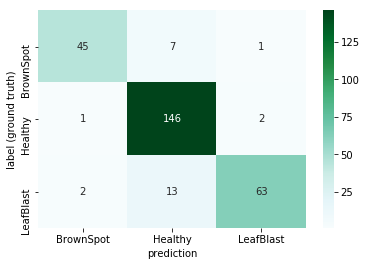

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 225	TRAIN	Loss: 0.11	Correct: 2306/2510(91.87%)
		VALID.:	Loss: 0.37	Correct: 253/280(90.36%)
----------------------------------------


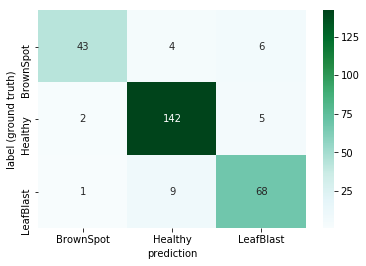

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 226	TRAIN	Loss: 0.02	Correct: 2293/2510(91.35%)
		VALID.:	Loss: 0.16	Correct: 259/280(92.5%)
----------------------------------------


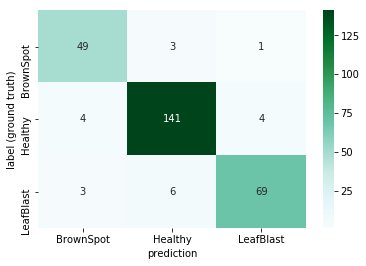

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 227	TRAIN	Loss: 0.11	Correct: 2287/2510(91.12%)
		VALID.:	Loss: 0.14	Correct: 258/280(92.14%)
----------------------------------------


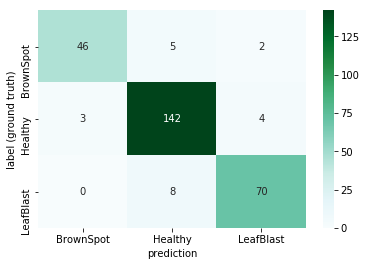

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 228	TRAIN	Loss: 0.28	Correct: 2286/2510(91.08%)
		VALID.:	Loss: 0.4	Correct: 259/280(92.5%)
----------------------------------------


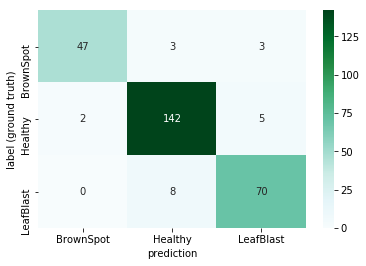

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 229	TRAIN	Loss: 0.45	Correct: 2285/2510(91.04%)
		VALID.:	Loss: 0.21	Correct: 260/280(92.86%)
----------------------------------------


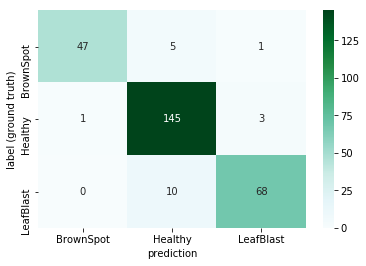

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 230	TRAIN	Loss: 0.08	Correct: 2304/2510(91.79%)
		VALID.:	Loss: 0.42	Correct: 260/280(92.86%)
----------------------------------------


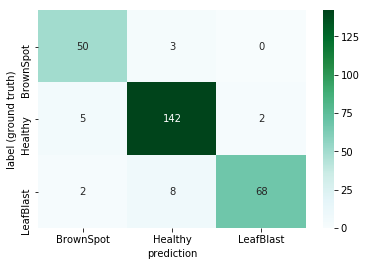

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 231	TRAIN	Loss: 0.27	Correct: 2292/2510(91.31%)
		VALID.:	Loss: 0.35	Correct: 251/280(89.64%)
----------------------------------------


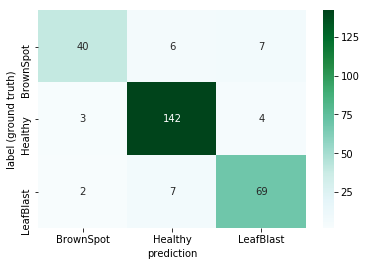

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 232	TRAIN	Loss: 0.41	Correct: 2280/2510(90.84%)
		VALID.:	Loss: 0.3	Correct: 257/280(91.79%)
----------------------------------------


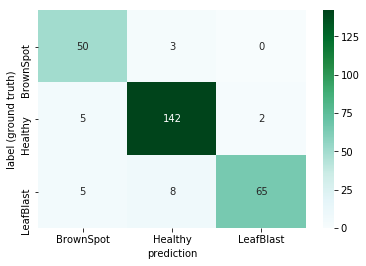

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 233	TRAIN	Loss: 0.06	Correct: 2272/2510(90.52%)
		VALID.:	Loss: 0.42	Correct: 253/280(90.36%)
----------------------------------------


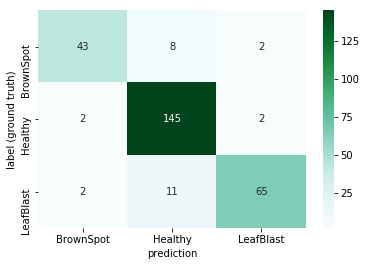

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 234	TRAIN	Loss: 0.46	Correct: 2299/2510(91.59%)
		VALID.:	Loss: 0.49	Correct: 247/280(88.21%)
----------------------------------------


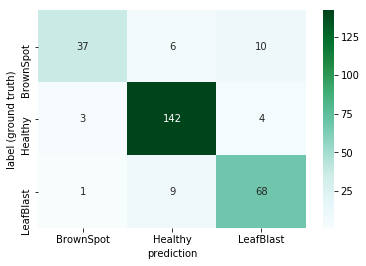

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 235	TRAIN	Loss: 0.37	Correct: 2280/2510(90.84%)
		VALID.:	Loss: 0.22	Correct: 258/280(92.14%)
----------------------------------------


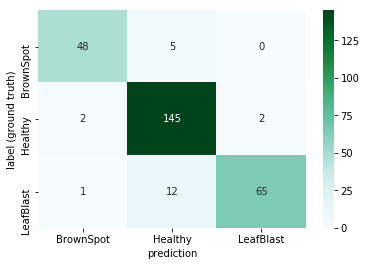

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 236	TRAIN	Loss: 0.19	Correct: 2294/2510(91.39%)
		VALID.:	Loss: 0.1	Correct: 262/280(93.57%)
----------------------------------------


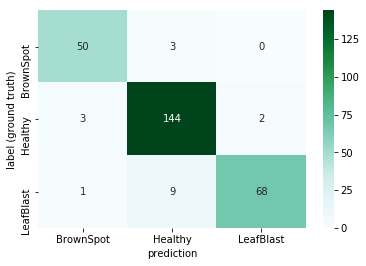

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 237	TRAIN	Loss: 0.37	Correct: 2309/2510(91.99%)
		VALID.:	Loss: 0.37	Correct: 259/280(92.5%)
----------------------------------------


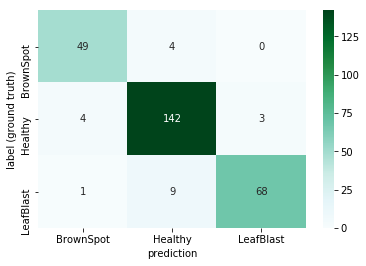

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 238	TRAIN	Loss: 0.51	Correct: 2298/2510(91.55%)
		VALID.:	Loss: 0.22	Correct: 255/280(91.07%)
----------------------------------------


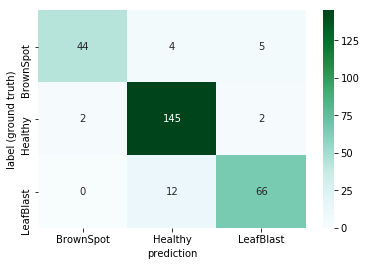

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 239	TRAIN	Loss: 0.31	Correct: 2302/2510(91.71%)
		VALID.:	Loss: 0.16	Correct: 261/280(93.21%)
----------------------------------------


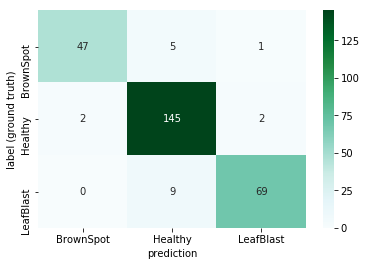

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 240	TRAIN	Loss: 0.63	Correct: 2292/2510(91.31%)
		VALID.:	Loss: 0.38	Correct: 257/280(91.79%)
----------------------------------------


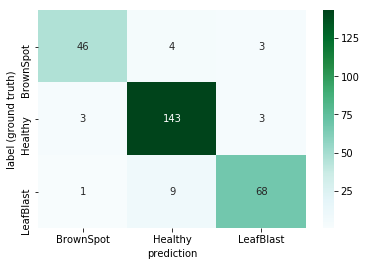

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 241	TRAIN	Loss: 0.09	Correct: 2293/2510(91.35%)
		VALID.:	Loss: 0.35	Correct: 260/280(92.86%)
----------------------------------------


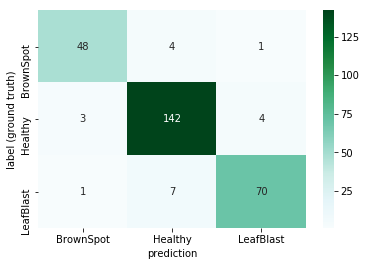

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 242	TRAIN	Loss: 0.23	Correct: 2314/2510(92.19%)
		VALID.:	Loss: 0.29	Correct: 258/280(92.14%)
----------------------------------------


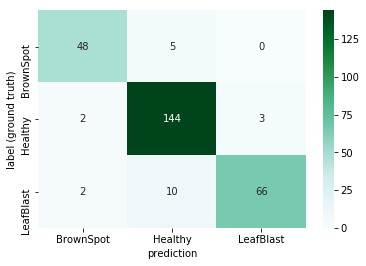

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 243	TRAIN	Loss: 0.17	Correct: 2304/2510(91.79%)
		VALID.:	Loss: 0.33	Correct: 257/280(91.79%)
----------------------------------------


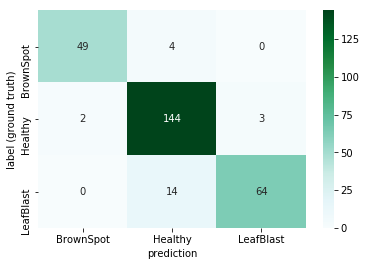

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 244	TRAIN	Loss: 0.28	Correct: 2316/2510(92.27%)
		VALID.:	Loss: 0.44	Correct: 261/280(93.21%)
----------------------------------------


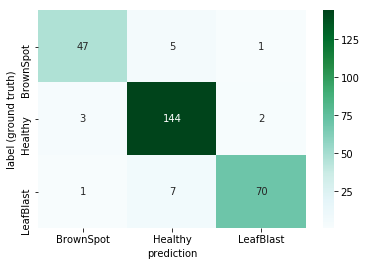

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 245	TRAIN	Loss: 0.15	Correct: 2302/2510(91.71%)
		VALID.:	Loss: 0.4	Correct: 258/280(92.14%)
----------------------------------------


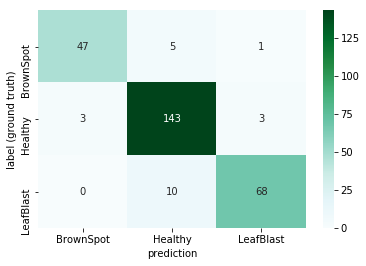

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 246	TRAIN	Loss: 0.38	Correct: 2312/2510(92.11%)
		VALID.:	Loss: 0.29	Correct: 258/280(92.14%)
----------------------------------------


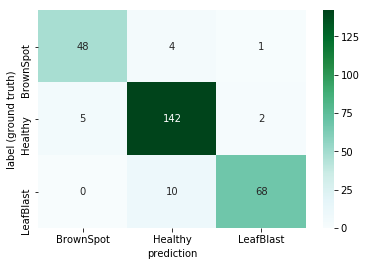

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 247	TRAIN	Loss: 0.13	Correct: 2314/2510(92.19%)
		VALID.:	Loss: 0.19	Correct: 260/280(92.86%)
----------------------------------------


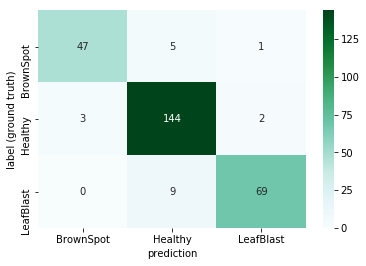

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 248	TRAIN	Loss: 0.28	Correct: 2282/2510(90.92%)
		VALID.:	Loss: 0.21	Correct: 261/280(93.21%)
----------------------------------------


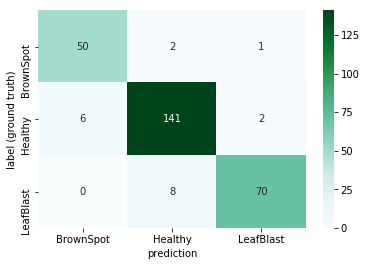

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 249	TRAIN	Loss: 0.25	Correct: 2314/2510(92.19%)
		VALID.:	Loss: 0.24	Correct: 254/280(90.71%)
----------------------------------------


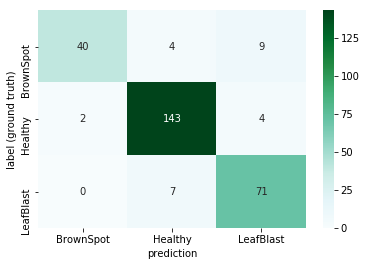

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 250	TRAIN	Loss: 0.12	Correct: 2310/2510(92.03%)
		VALID.:	Loss: 0.39	Correct: 261/280(93.21%)
----------------------------------------


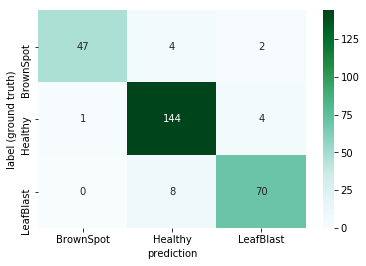

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 251	TRAIN	Loss: 0.03	Correct: 2306/2510(91.87%)
		VALID.:	Loss: 0.29	Correct: 255/280(91.07%)
----------------------------------------


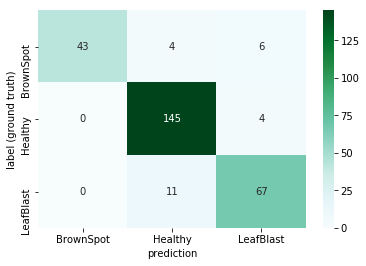

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 252	TRAIN	Loss: 0.35	Correct: 2311/2510(92.07%)
		VALID.:	Loss: 0.36	Correct: 256/280(91.43%)
----------------------------------------


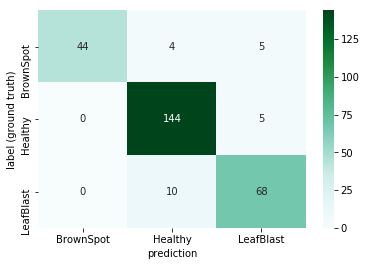

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 253	TRAIN	Loss: 0.13	Correct: 2280/2510(90.84%)
		VALID.:	Loss: 0.35	Correct: 254/280(90.71%)
----------------------------------------


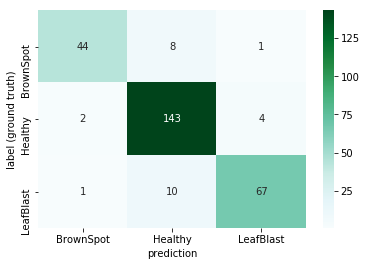

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 254	TRAIN	Loss: 0.27	Correct: 2289/2510(91.2%)
		VALID.:	Loss: 0.56	Correct: 253/280(90.36%)
----------------------------------------


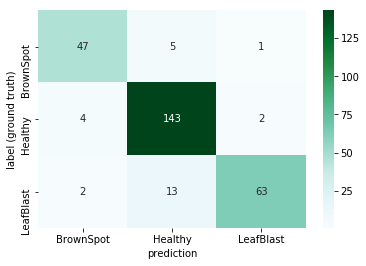

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 255	TRAIN	Loss: 0.23	Correct: 2300/2510(91.63%)
		VALID.:	Loss: 0.27	Correct: 258/280(92.14%)
----------------------------------------


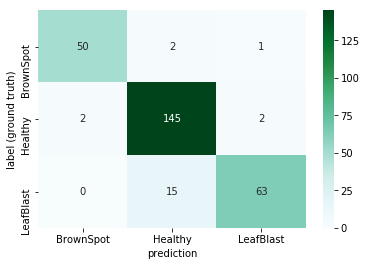

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 256	TRAIN	Loss: 0.2	Correct: 2297/2510(91.51%)
		VALID.:	Loss: 0.33	Correct: 258/280(92.14%)
----------------------------------------


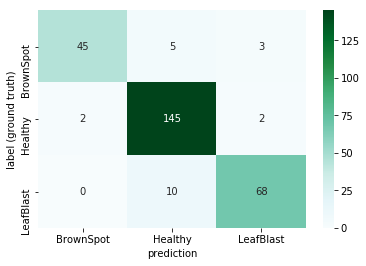

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 257	TRAIN	Loss: 0.27	Correct: 2295/2510(91.43%)
		VALID.:	Loss: 0.21	Correct: 255/280(91.07%)
----------------------------------------


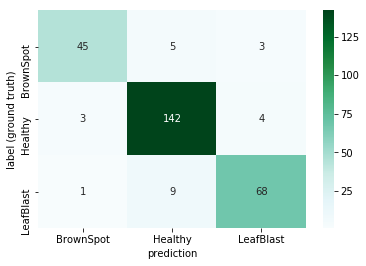

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 258	TRAIN	Loss: 0.08	Correct: 2296/2510(91.47%)
		VALID.:	Loss: 0.45	Correct: 258/280(92.14%)
----------------------------------------


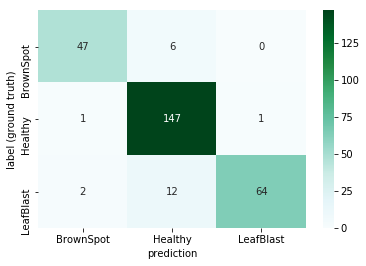

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 259	TRAIN	Loss: 0.23	Correct: 2298/2510(91.55%)
		VALID.:	Loss: 0.29	Correct: 256/280(91.43%)
----------------------------------------


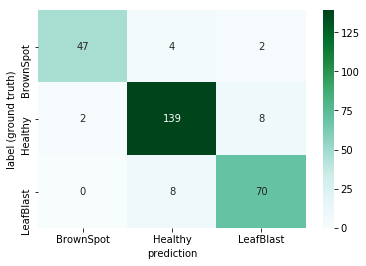

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 260	TRAIN	Loss: 0.06	Correct: 2289/2510(91.2%)
		VALID.:	Loss: 0.5	Correct: 248/280(88.57%)
----------------------------------------


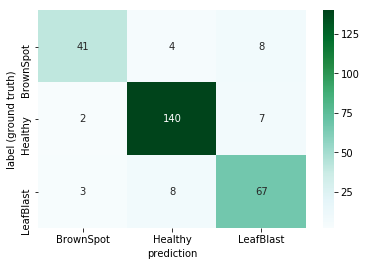

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 261	TRAIN	Loss: 0.25	Correct: 2300/2510(91.63%)
		VALID.:	Loss: 0.2	Correct: 258/280(92.14%)
----------------------------------------


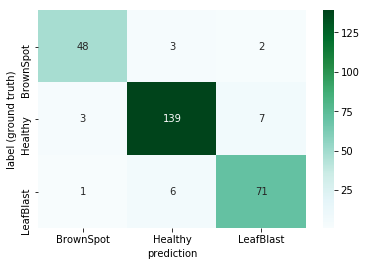

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 262	TRAIN	Loss: 0.04	Correct: 2319/2510(92.39%)
		VALID.:	Loss: 0.31	Correct: 262/280(93.57%)
----------------------------------------


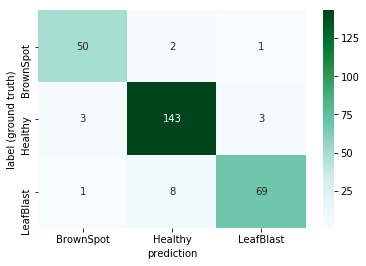

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 263	TRAIN	Loss: 0.47	Correct: 2282/2510(90.92%)
		VALID.:	Loss: 0.36	Correct: 256/280(91.43%)
----------------------------------------


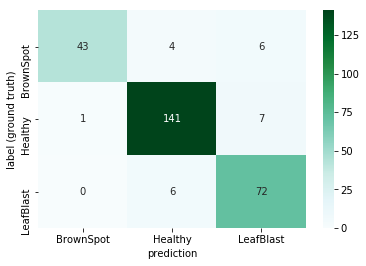

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 264	TRAIN	Loss: 0.18	Correct: 2308/2510(91.95%)
		VALID.:	Loss: 0.26	Correct: 259/280(92.5%)
----------------------------------------


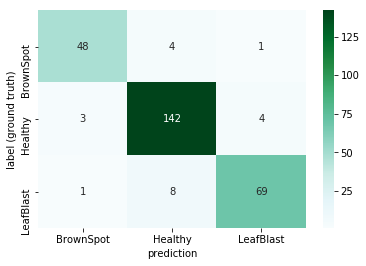

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 265	TRAIN	Loss: 0.39	Correct: 2334/2510(92.99%)
		VALID.:	Loss: 0.33	Correct: 256/280(91.43%)
----------------------------------------


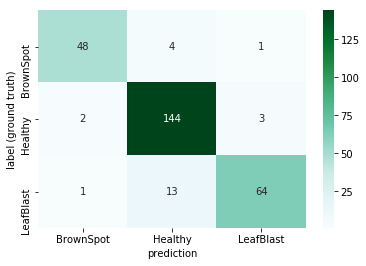

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 266	TRAIN	Loss: 0.09	Correct: 2294/2510(91.39%)
		VALID.:	Loss: 0.27	Correct: 255/280(91.07%)
----------------------------------------


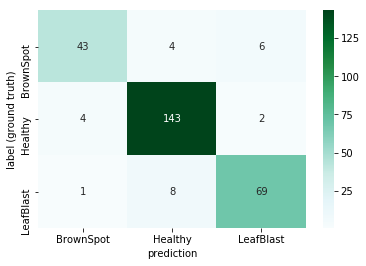

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 267	TRAIN	Loss: 0.29	Correct: 2302/2510(91.71%)
		VALID.:	Loss: 0.19	Correct: 258/280(92.14%)
----------------------------------------


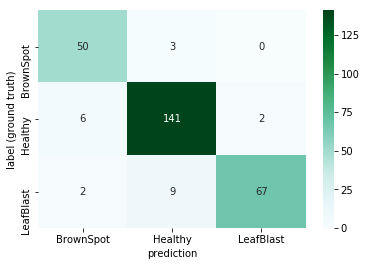

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 268	TRAIN	Loss: 0.25	Correct: 2305/2510(91.83%)
		VALID.:	Loss: 0.31	Correct: 254/280(90.71%)
----------------------------------------


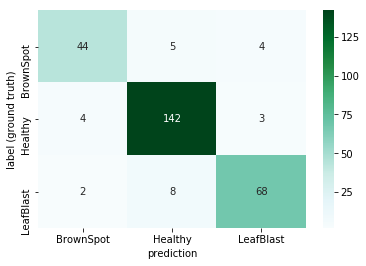

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 269	TRAIN	Loss: 0.06	Correct: 2293/2510(91.35%)
		VALID.:	Loss: 0.21	Correct: 258/280(92.14%)
----------------------------------------


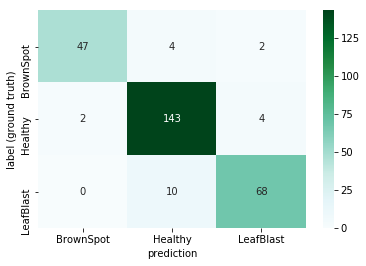

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 270	TRAIN	Loss: 0.05	Correct: 2333/2510(92.95%)
		VALID.:	Loss: 0.43	Correct: 253/280(90.36%)
----------------------------------------


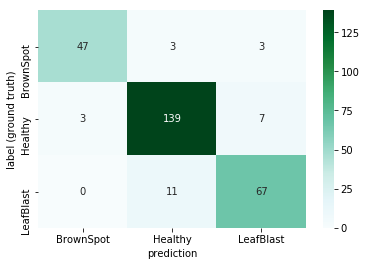

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 271	TRAIN	Loss: 0.3	Correct: 2310/2510(92.03%)
		VALID.:	Loss: 0.2	Correct: 251/280(89.64%)
----------------------------------------


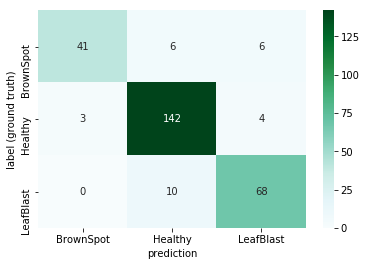

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 272	TRAIN	Loss: 0.15	Correct: 2297/2510(91.51%)
		VALID.:	Loss: 0.35	Correct: 259/280(92.5%)
----------------------------------------


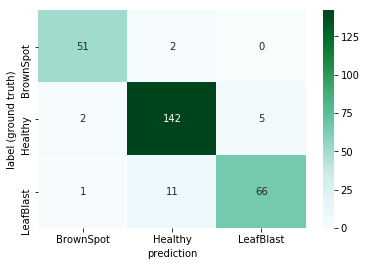

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 273	TRAIN	Loss: 0.45	Correct: 2294/2510(91.39%)
		VALID.:	Loss: 0.25	Correct: 255/280(91.07%)
----------------------------------------


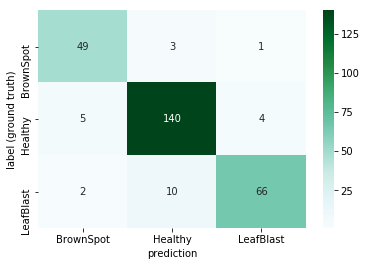

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 274	TRAIN	Loss: 0.16	Correct: 2309/2510(91.99%)
		VALID.:	Loss: 0.3	Correct: 259/280(92.5%)
----------------------------------------


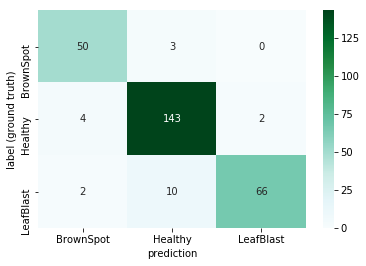

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 275	TRAIN	Loss: 0.03	Correct: 2311/2510(92.07%)
		VALID.:	Loss: 0.3	Correct: 262/280(93.57%)
----------------------------------------


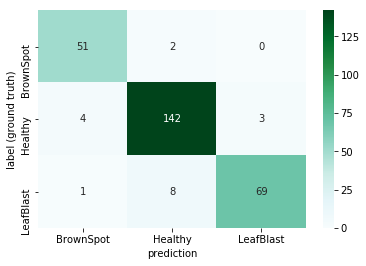

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 276	TRAIN	Loss: 0.11	Correct: 2305/2510(91.83%)
		VALID.:	Loss: 0.2	Correct: 259/280(92.5%)
----------------------------------------


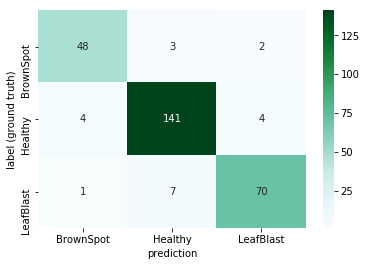

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 277	TRAIN	Loss: 0.09	Correct: 2305/2510(91.83%)
		VALID.:	Loss: 0.59	Correct: 256/280(91.43%)
----------------------------------------


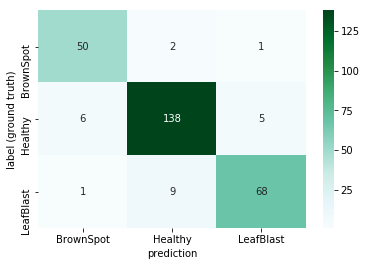

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 278	TRAIN	Loss: 0.23	Correct: 2315/2510(92.23%)
		VALID.:	Loss: 0.37	Correct: 260/280(92.86%)
----------------------------------------


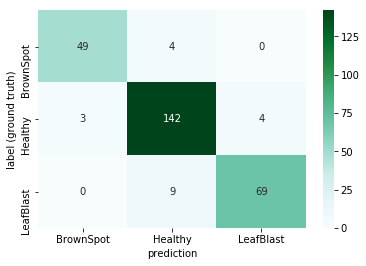

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 279	TRAIN	Loss: 0.13	Correct: 2315/2510(92.23%)
		VALID.:	Loss: 0.41	Correct: 259/280(92.5%)
----------------------------------------


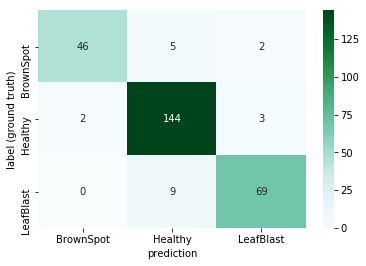

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 280	TRAIN	Loss: 0.19	Correct: 2312/2510(92.11%)
		VALID.:	Loss: 0.12	Correct: 261/280(93.21%)
----------------------------------------


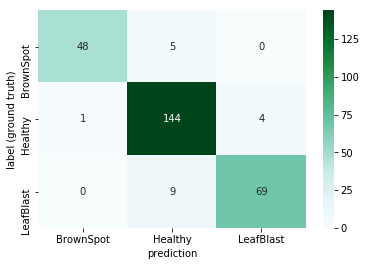

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 281	TRAIN	Loss: 0.21	Correct: 2325/2510(92.63%)
		VALID.:	Loss: 0.25	Correct: 258/280(92.14%)
----------------------------------------


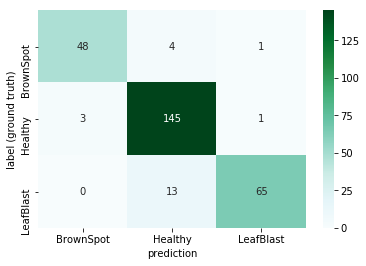

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 282	TRAIN	Loss: 0.2	Correct: 2308/2510(91.95%)
		VALID.:	Loss: 0.34	Correct: 256/280(91.43%)
----------------------------------------


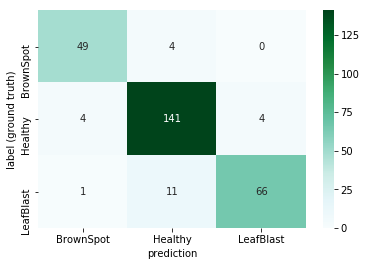

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 283	TRAIN	Loss: 0.23	Correct: 2340/2510(93.23%)
		VALID.:	Loss: 0.21	Correct: 259/280(92.5%)
----------------------------------------


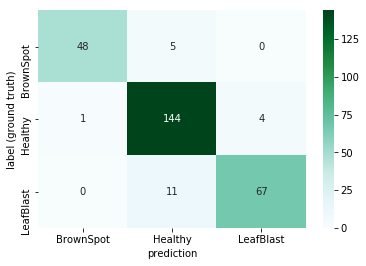

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 284	TRAIN	Loss: 0.17	Correct: 2308/2510(91.95%)
		VALID.:	Loss: 0.29	Correct: 258/280(92.14%)
----------------------------------------


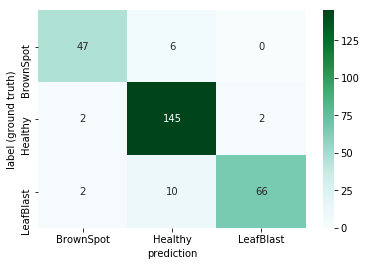

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 285	TRAIN	Loss: 0.11	Correct: 2334/2510(92.99%)
		VALID.:	Loss: 0.31	Correct: 252/280(90.0%)
----------------------------------------


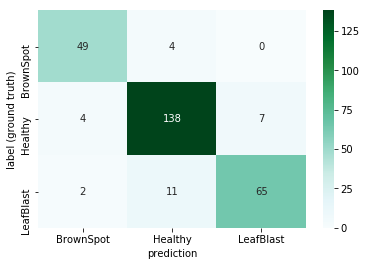

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 286	TRAIN	Loss: 0.2	Correct: 2329/2510(92.79%)
		VALID.:	Loss: 0.47	Correct: 260/280(92.86%)
----------------------------------------


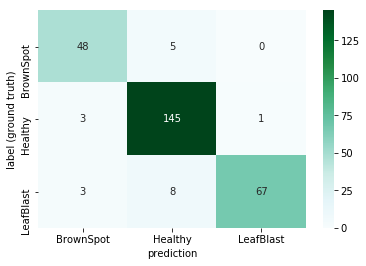

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 287	TRAIN	Loss: 0.13	Correct: 2302/2510(91.71%)
		VALID.:	Loss: 0.29	Correct: 259/280(92.5%)
----------------------------------------


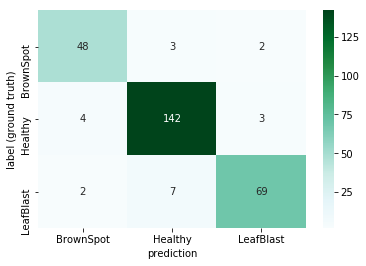

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 288	TRAIN	Loss: 0.12	Correct: 2320/2510(92.43%)
		VALID.:	Loss: 0.42	Correct: 259/280(92.5%)
----------------------------------------


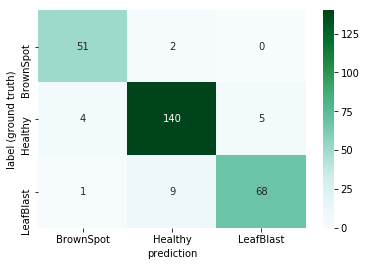

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 289	TRAIN	Loss: 0.14	Correct: 2304/2510(91.79%)
		VALID.:	Loss: 0.27	Correct: 260/280(92.86%)
----------------------------------------


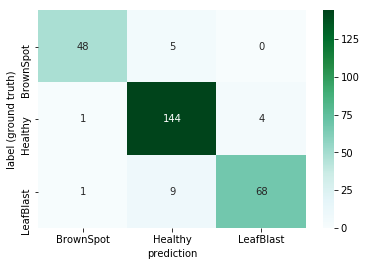

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 290	TRAIN	Loss: 0.14	Correct: 2306/2510(91.87%)
		VALID.:	Loss: 0.1	Correct: 256/280(91.43%)
----------------------------------------


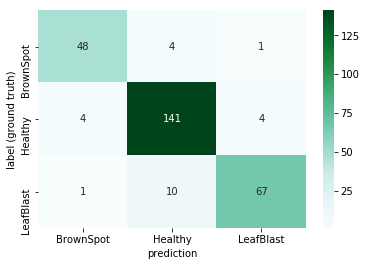

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 291	TRAIN	Loss: 0.05	Correct: 2313/2510(92.15%)
		VALID.:	Loss: 0.32	Correct: 255/280(91.07%)
----------------------------------------


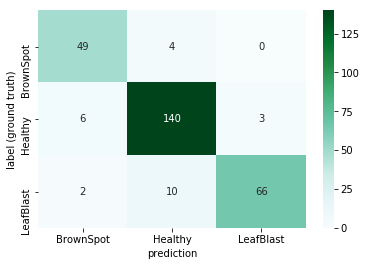

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 292	TRAIN	Loss: 0.42	Correct: 2319/2510(92.39%)
		VALID.:	Loss: 0.29	Correct: 254/280(90.71%)
----------------------------------------


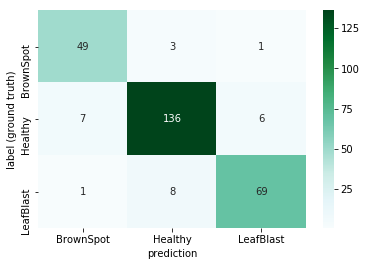

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 293	TRAIN	Loss: 0.16	Correct: 2335/2510(93.03%)
		VALID.:	Loss: 0.34	Correct: 261/280(93.21%)
----------------------------------------


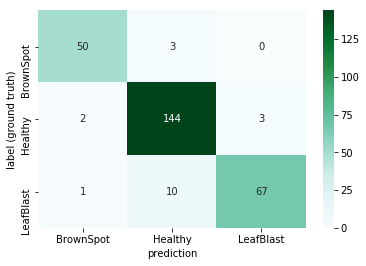

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 294	TRAIN	Loss: 0.73	Correct: 2322/2510(92.51%)
		VALID.:	Loss: 0.52	Correct: 255/280(91.07%)
----------------------------------------


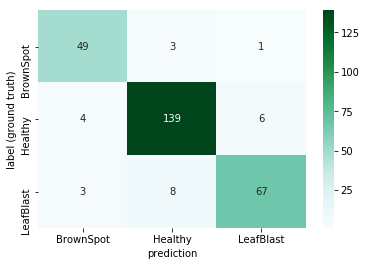

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 295	TRAIN	Loss: 0.04	Correct: 2325/2510(92.63%)
		VALID.:	Loss: 0.32	Correct: 258/280(92.14%)
----------------------------------------


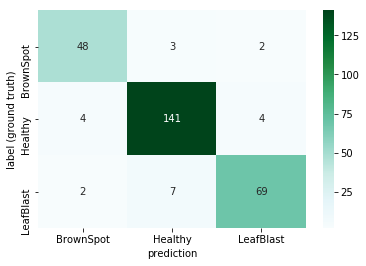

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 296	TRAIN	Loss: 0.25	Correct: 2307/2510(91.91%)
		VALID.:	Loss: 0.32	Correct: 261/280(93.21%)
----------------------------------------


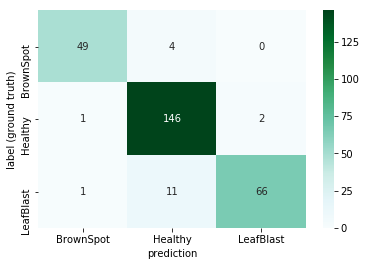

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 297	TRAIN	Loss: 0.42	Correct: 2335/2510(93.03%)
		VALID.:	Loss: 0.06	Correct: 257/280(91.79%)
----------------------------------------


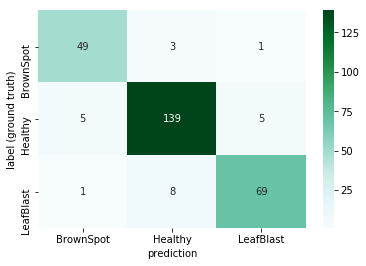

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 298	TRAIN	Loss: 0.36	Correct: 2331/2510(92.87%)
		VALID.:	Loss: 0.4	Correct: 255/280(91.07%)
----------------------------------------


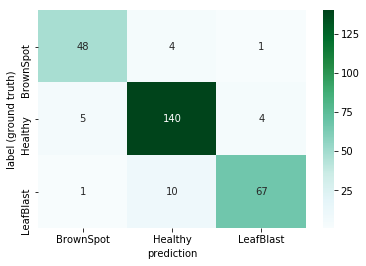

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 299	TRAIN	Loss: 0.03	Correct: 2352/2510(93.71%)
		VALID.:	Loss: 0.31	Correct: 250/280(89.29%)
----------------------------------------


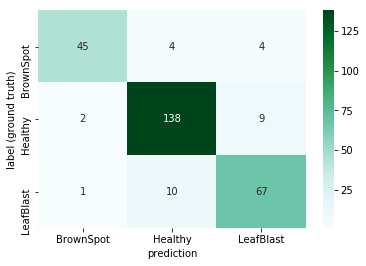

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 300	TRAIN	Loss: 0.03	Correct: 2328/2510(92.75%)
		VALID.:	Loss: 0.41	Correct: 255/280(91.07%)
----------------------------------------


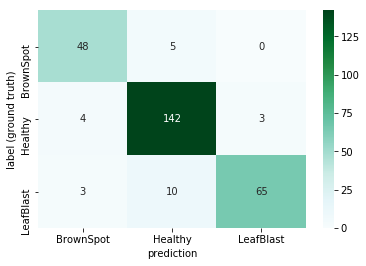

End.
Duration: 24743 seconds


'googlenet_e211_best94.29'

In [30]:
best_model_prefix = ['']

train(model_googlenet, criterion, optimizer,
      train_loader, valid_loader, 
      n_epoch=300, device=DEVICE,
      out_train_losses=train_losses,
      out_valid_losses=valid_losses,
      out_train_corrects=train_corrects,
      out_valid_corrects=valid_corrects,
      out_best_model_prefix=best_model_prefix,
      prefix='googlenet')

Validation accuracy: 94.29 %


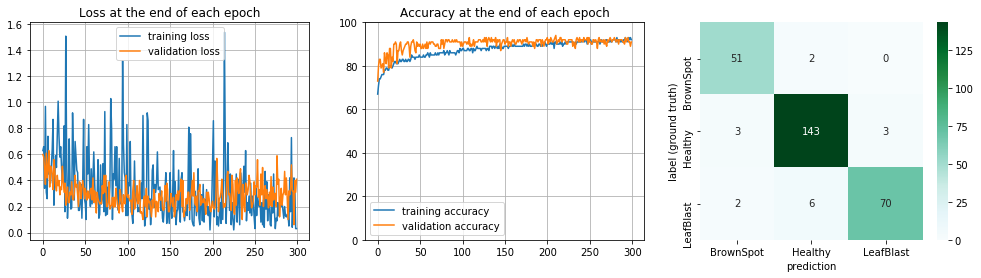

In [31]:
best_model_googlenet = copy.deepcopy(model_googlenet)
restore_progress(best_model_googlenet, optimizer,
                 [], [], [], [],
                 best_model_prefix[0], 'progress')

plot_train_report(best_model_googlenet, 
                  train_loader, valid_loader,
                  train_losses, valid_losses, train_corrects, valid_corrects,
                  DEVICE)